In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [2]:
casestore = dict()

In [3]:
   
db = CaseDB()
toload = [

    dict(name="afnBseplims_mfp1", id = "d22bba-tunefrec_seplims_mfp1.0"),
    dict(name="afnD_mfp1", id = "d22eb-also_mfp1"),
    dict(name="afnE_mfp1", id = "d24b-tunefrec_E_AFN_mfp1.0"),
    dict(name="afnE_mfp0.1", id = "d24a-tunefrec_E_AFN_mfp0.1"),
    dict(name="afnE_mfp10", id = "d22ec-also_mfp10"),
    dict(name="afnE_mfp1_cond0.75", id = "d24ba-E_mfp1_cond0.75"),
    dict(name="afnE_mfp1_cond0.5", id = "d24bb-E_mfp1_cond0.5"),
    dict(name="afnE_mfp1_cond0.25", id = "d24bc-E_mfp1_cond0.25"),
    dict(name="afnE_mfp1_cond0.25_flim0.9", id = "d24bcab-hipump_flim_0.9"),
    dict(name="afnE_mfp1_cond0.25_flim0.7", id = "d24bcac-hipump_flim_0.7"),
    dict(name="afnE_mfp1_cond0.25_flim0.5", id = "d24bcad-hipump_flim_0.5"),
    dict(name="afnE_mfp1_cond0.25_flim0.25", id = "d24bcae-hipump_flim_0.25"),
    dict(name="afnE_mfp1_cond0.25_frec0.48", id = "d24bd-cond0.25_frec0.48"),
    dict(name="afnE_mfp1_cond0.25_frec0.68", id = "d24bdb-cond0.25_frec0.68"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Reading case d22bba-tunefrec_seplims_mfp1.0
-----------------------
- Looking for squash file
- Squash file found. squash date 10/13/2023, 12:39:13, dmp file date 10/15/2023, 06:28:37
- dmp files are newer than the squash file! Recreating...
- Done

- Reading case d22eb-also_mfp1
-----------------------
- Looking for squash file
- Squash file found. squash date 10/15/2023, 22:01:34, dmp file date 10/12/2023, 19:56:05

- Reading case d24b-tunefrec_E_AFN_mfp1.0
-----------------------
- Looking for squash file
- Squash file found. squash date 10/15/2023, 22:03:01, dmp file date 10/13/2023, 18:12:51

- Reading case d24a-tunefrec_E_AFN_mfp0.1
-----------------------
- Looking for squash file
- Squash file found. squash date 10/13/2023, 15:45:20, dmp file date 10/13/2023, 03:54:09

- Reading case d22ec-also_mfp10
-----------------------
- Looking for squash file
- Squash file found. squash date 10/12/2023, 11:02:41, dmp file date 10/12/2023, 09:41:42

- Reading case d24ba-E_mfp1_cond0.75


In [4]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [5]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnBseplims_mfp1
Loading afnBseplims_mfp1 with old AFN
afnD_mfp1
Loading afnD_mfp1 with old AFN
afnE_mfp1
Loading afnE_mfp1 with new AFN
afnE_mfp0.1
Loading afnE_mfp0.1 with new AFN
afnE_mfp10
Loading afnE_mfp10 with new AFN
afnE_mfp1_cond0.75
Loading afnE_mfp1_cond0.75 with new AFN
afnE_mfp1_cond0.5
Loading afnE_mfp1_cond0.5 with new AFN
afnE_mfp1_cond0.25
Loading afnE_mfp1_cond0.25 with new AFN
afnE_mfp1_cond0.25_flim0.9
Loading afnE_mfp1_cond0.25_flim0.9 with new AFN
afnE_mfp1_cond0.25_flim0.7
Loading afnE_mfp1_cond0.25_flim0.7 with new AFN
afnE_mfp1_cond0.25_flim0.5
Loading afnE_mfp1_cond0.25_flim0.5 with new AFN
afnE_mfp1_cond0.25_flim0.25
Loading afnE_mfp1_cond0.25_flim0.25 with new AFN
afnE_mfp1_cond0.25_frec0.48
Loading afnE_mfp1_cond0.25_frec0.48 with new AFN
afnE_mfp1_cond0.25_frec0.68
Loading afnE_mfp1_cond0.25_frec0.68 with new AFN


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [7]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [8]:
casestore.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp1', 'afnE_mfp0.1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25', 'afnE_mfp1_cond0.25_flim0.9', 'afnE_mfp1_cond0.25_flim0.7', 'afnE_mfp1_cond0.25_flim0.5', 'afnE_mfp1_cond0.25_flim0.25', 'afnE_mfp1_cond0.25_frec0.48', 'afnE_mfp1_cond0.25_frec0.68'])

# Performance

Text(0.5, 1.0, 'Timestep cost')

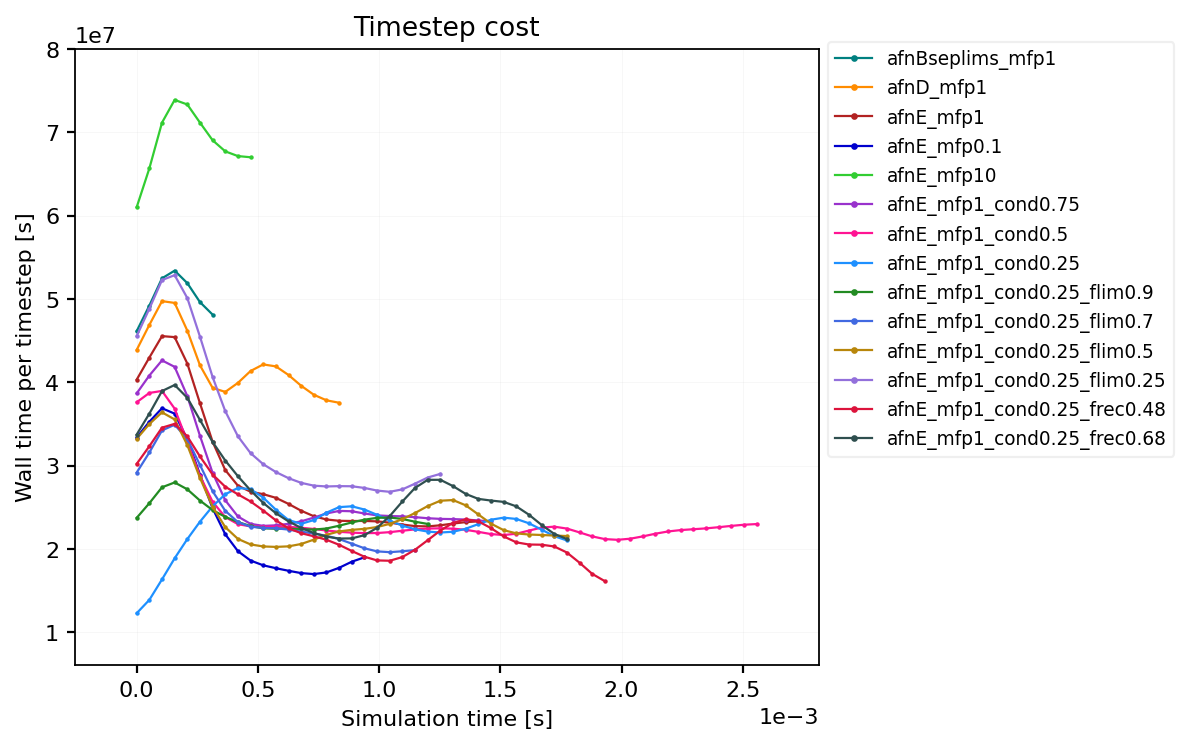

In [9]:
fig, ax = plt.subplots(dpi = 160)

colors = ["cyan", "darkgreen", "limegreen", "crimson", "firebrick", "red", "gold", "darkorange", ]

# cases = ["afnnew_mfp0.1", "afnnew_mfp1", "afnnew_mfp10"]
cases = casestore
for i, case in enumerate(cases):
    ds = casestore[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values
    time = time - [time[0]]

    
    ax.plot(time, scipy.ndimage.gaussian_filter1d(wtime_per_tstep, 2), label = case, 
            # color = colors[i], 
            lw = 1, marker = "o", ms = 1)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Timestep cost")
# ax.set_yscale("log")
# ax.set_xlim(None,0.614688)

# AFN comparison - MFP1

In [13]:
casestore.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25'])

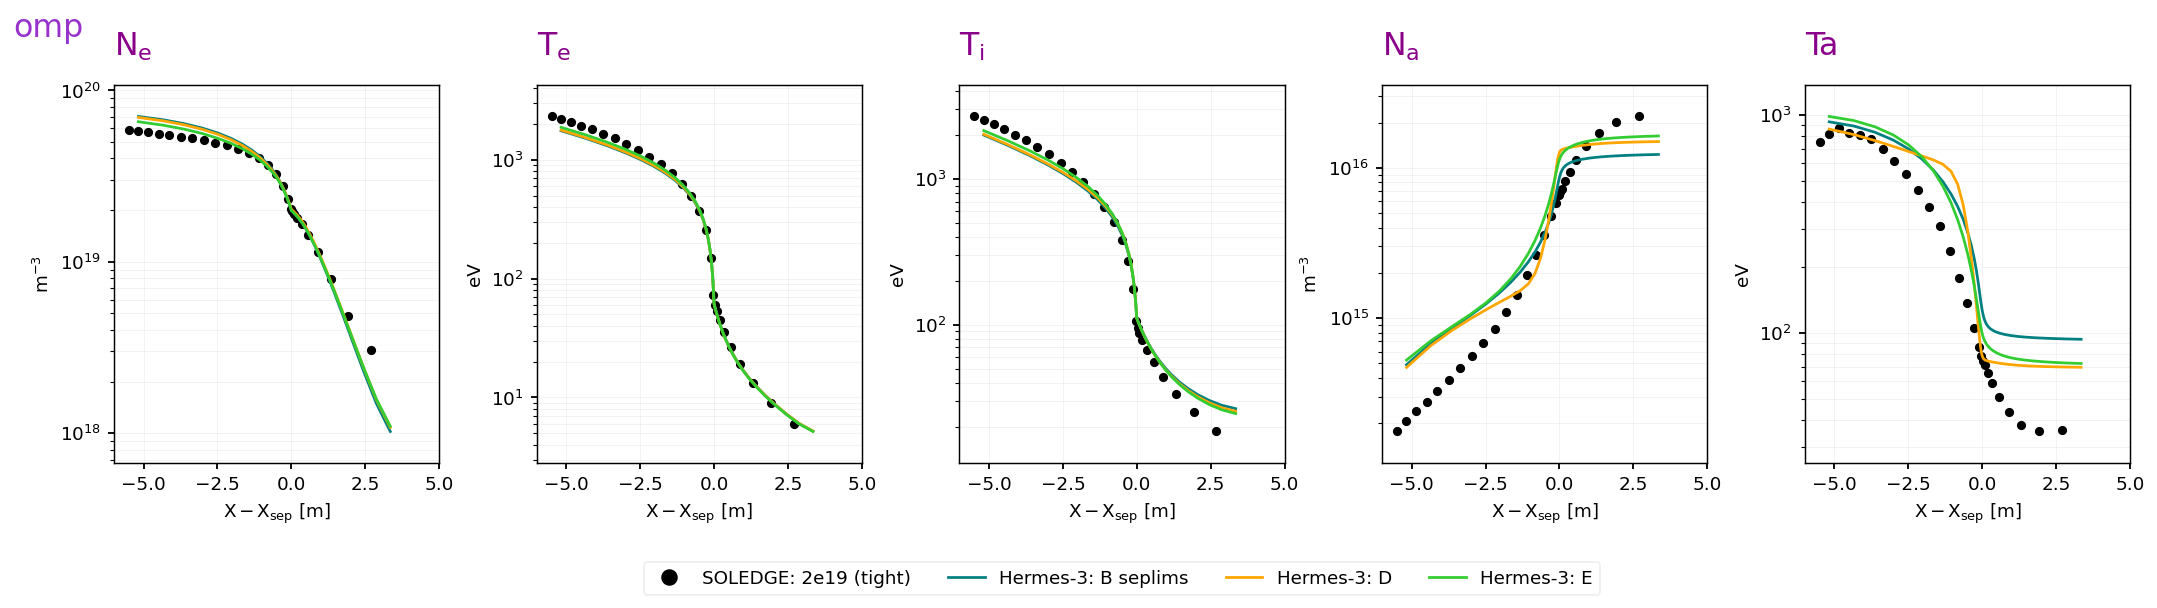

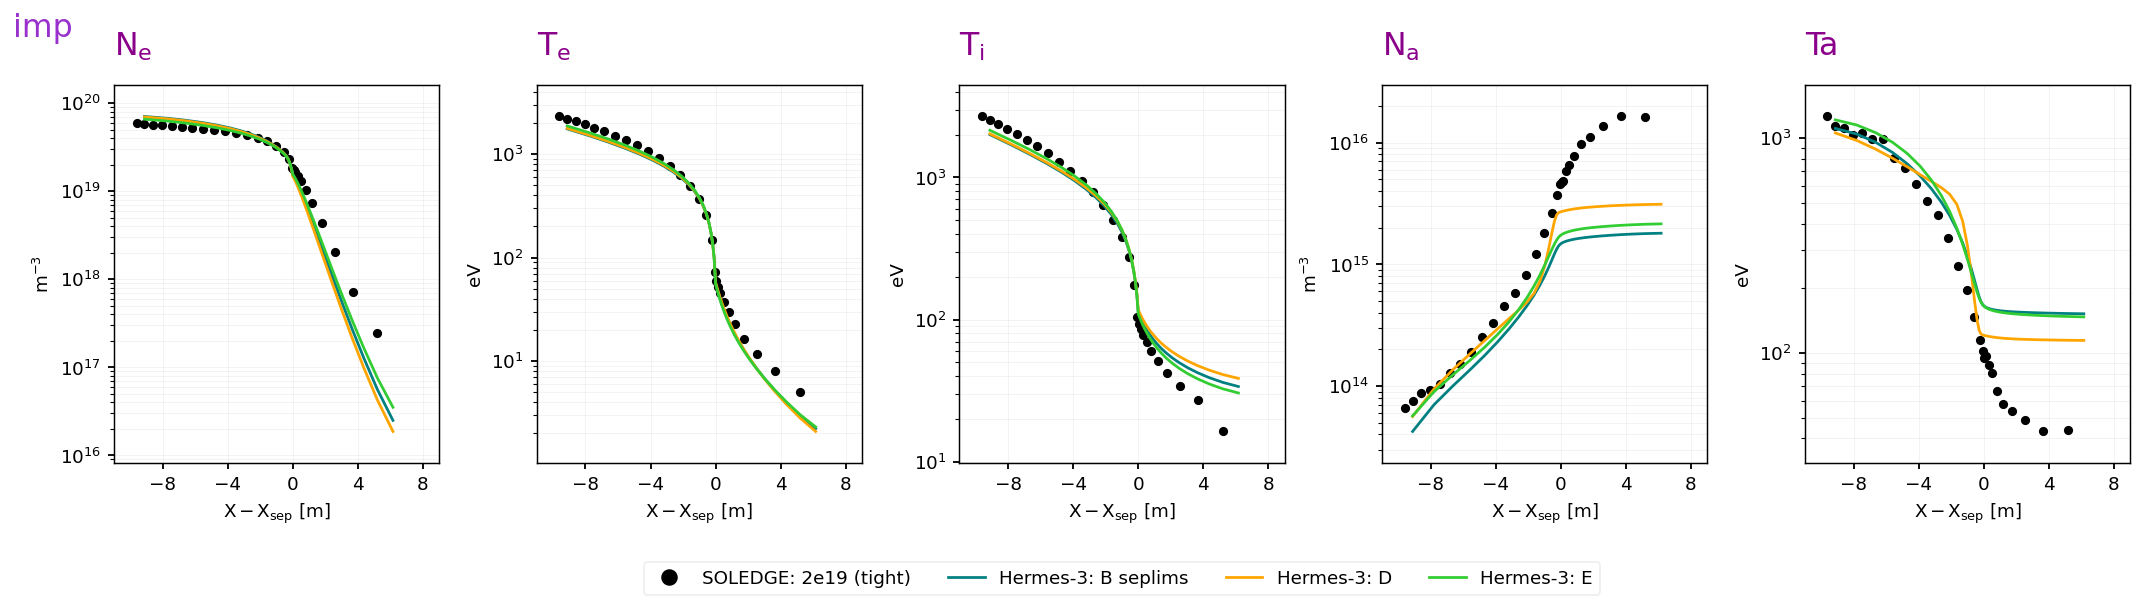

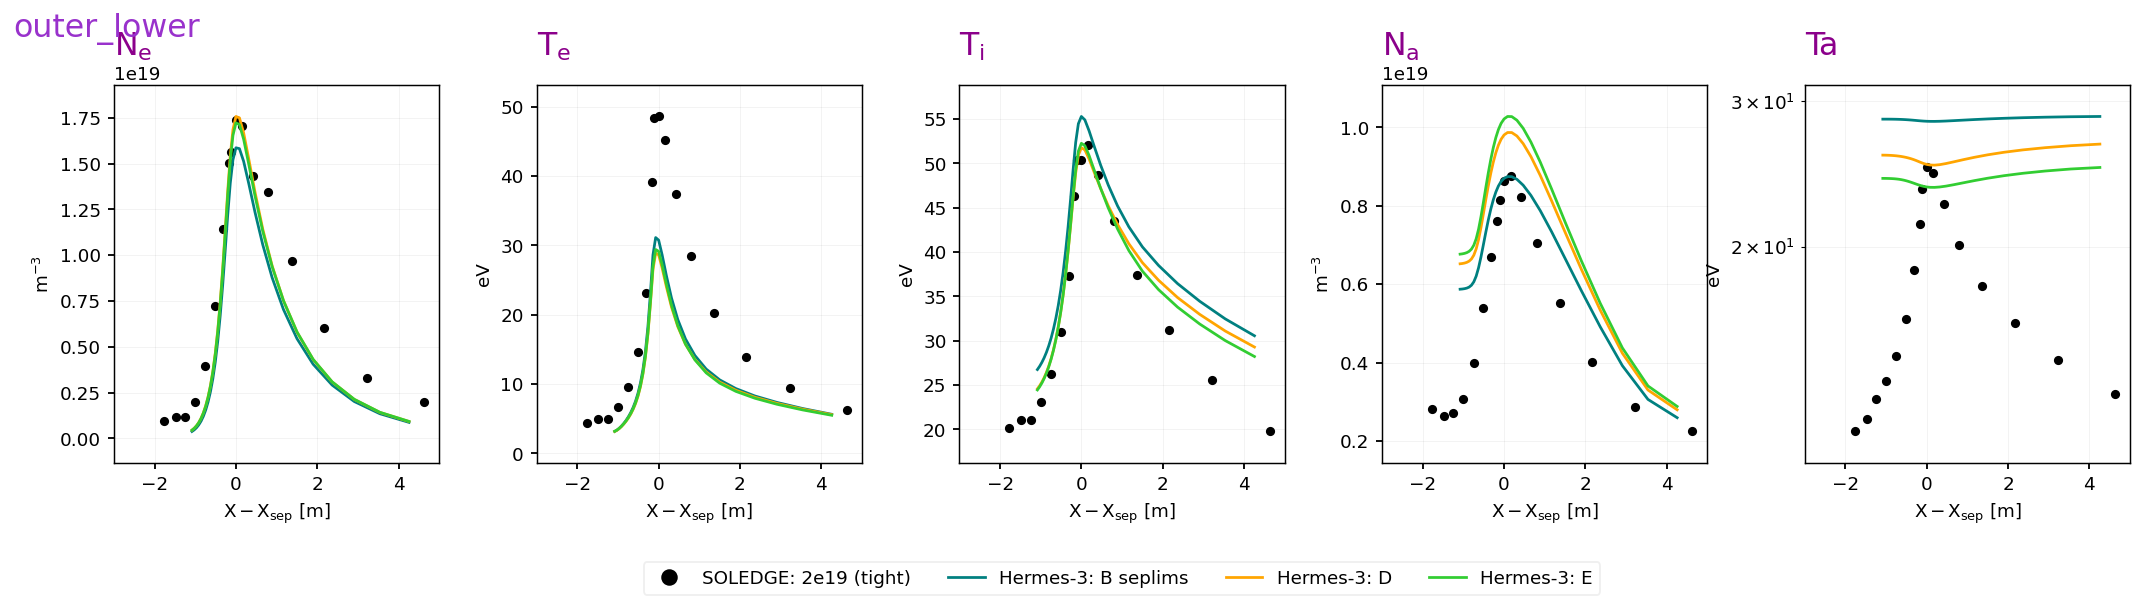

In [11]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    # "SOLPS: 2e19 (tight)" : dict(data=sp["nsep_3e19"], color="red"),
    
    # "Hermes-3: frec tune" : dict(data=hr['frec_tune'], color = "teal"),
    # r"Hermes-3: combined cond/conv" : dict(data=hr['afn_tunefrec'], color = "darkorange"),
    r"Hermes-3: B seplims" : dict(data=hr['afnBseplims_mfp1'], color = "teal"),
    r"Hermes-3: D" : dict(data=hr['afnD_mfp1'], color = "orange"),
    r"Hermes-3: E" : dict(data=hr['afnE_mfp1'], color = "limegreen"),
    # r"Hermes-3: New, MFP=10m" : dict(data=hr['afnnew_mfp10'], color = "deeppink"),

    },
    regions = ["omp", "imp", "outer_lower"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    mode = "log",
    dpi = 120,
    lw = 2
)

# Impact of reducing conductivity

In [22]:
hr.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25'])

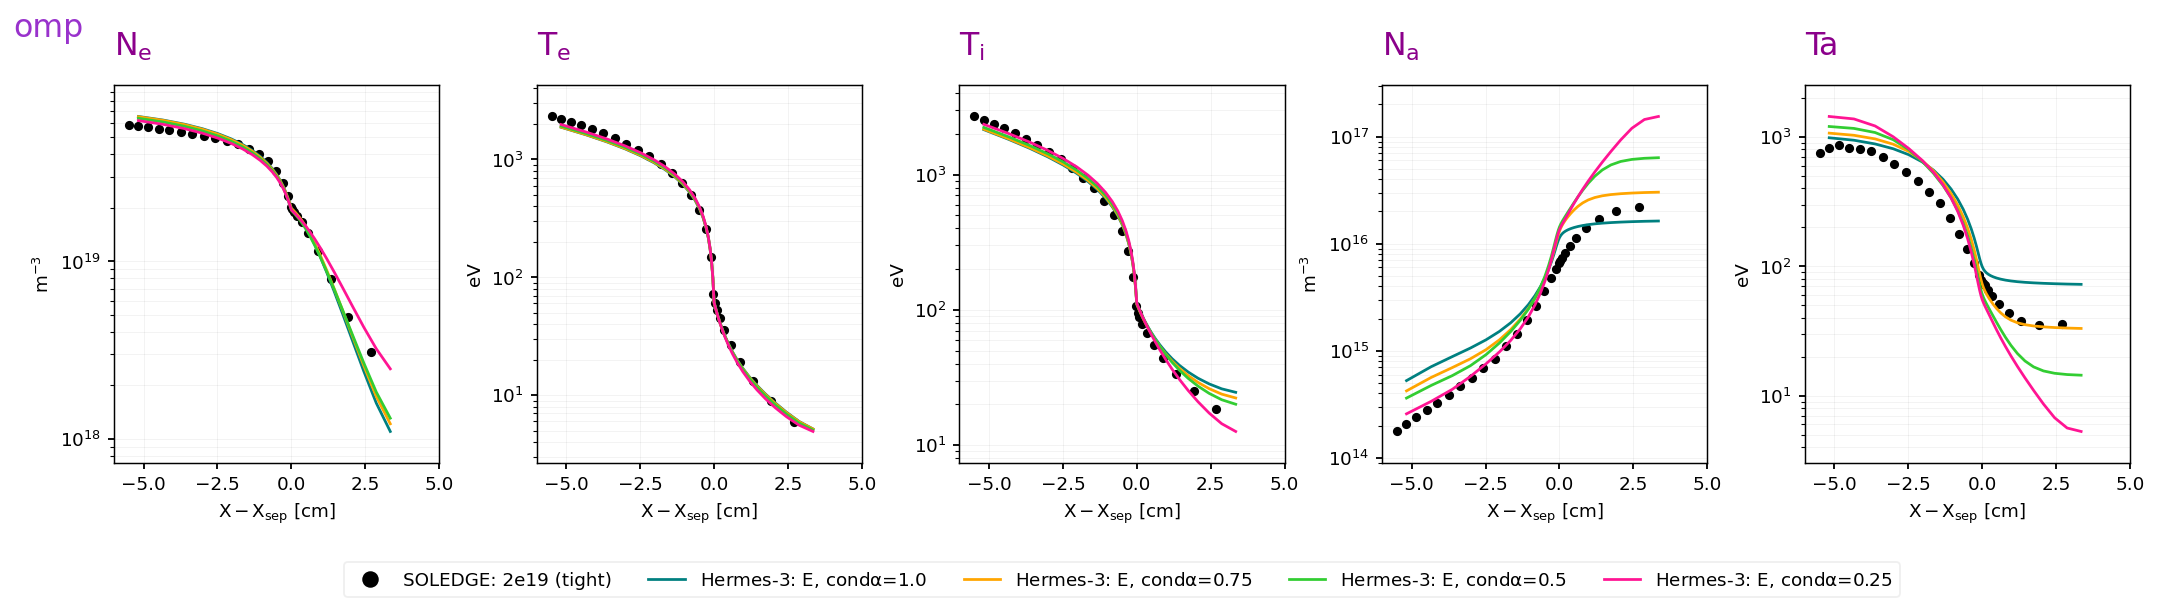

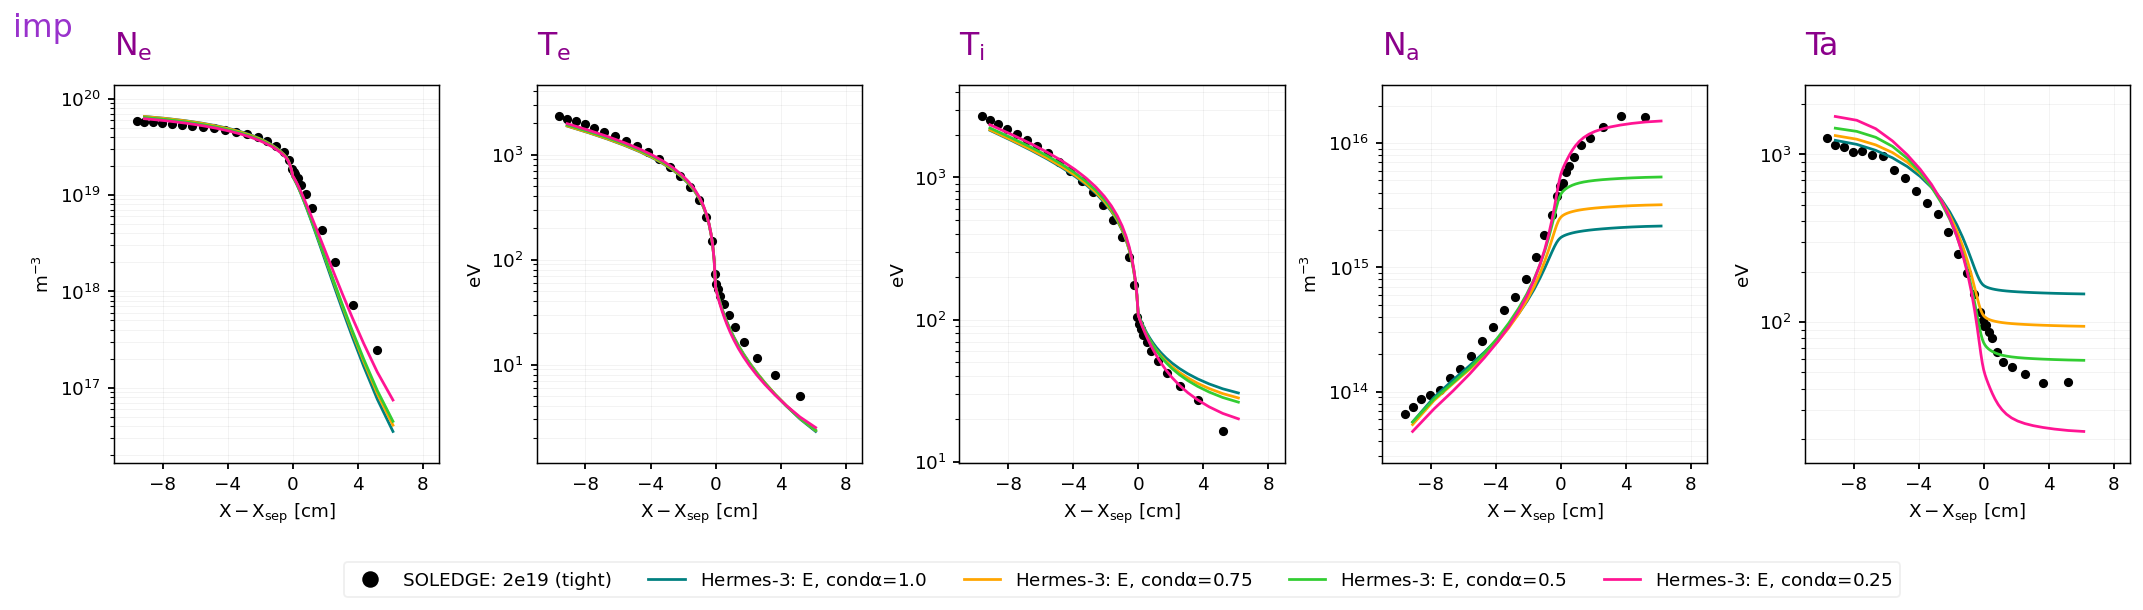

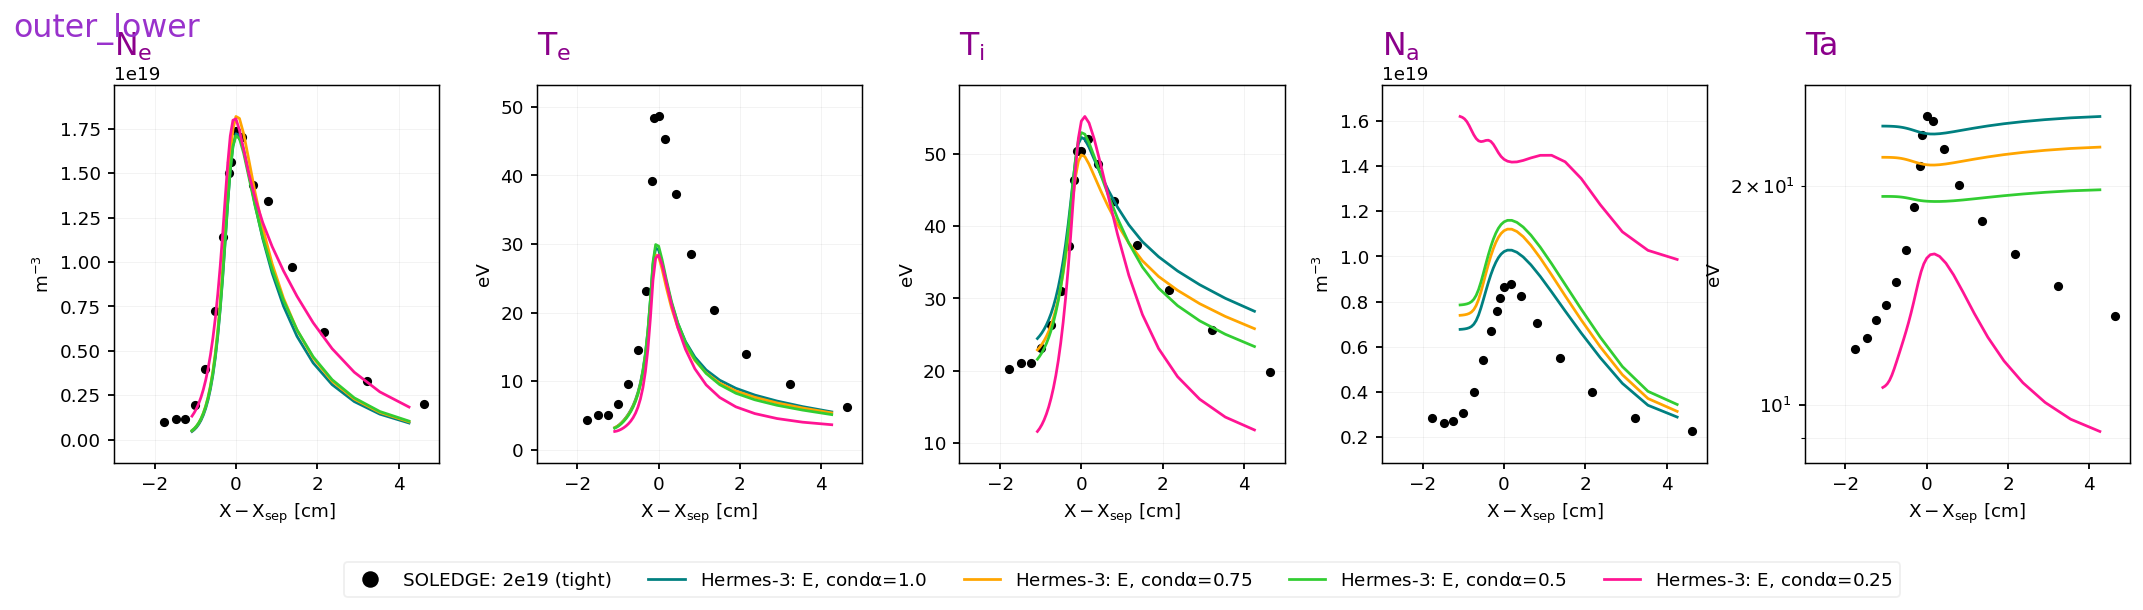

In [14]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    # "SOLPS: 2e19 (tight)" : dict(data=sp["nsep_3e19"], color="red"),
    
    # "Hermes-3: frec tune" : dict(data=hr['frec_tune'], color = "teal"),
    # r"Hermes-3: combined cond/conv" : dict(data=hr['afn_tunefrec'], color = "darkorange"),
    r"Hermes-3: E, cond$\alpha$=1.0" : dict(data=hr['afnE_mfp1'], color = "teal"),
    r"Hermes-3: E, cond$\alpha$=0.75" : dict(data=hr['afnE_mfp1_cond0.75'], color = "orange"),
    r"Hermes-3: E, cond$\alpha$=0.5" : dict(data=hr['afnE_mfp1_cond0.5'], color = "limegreen"),
    r"Hermes-3: E, cond$\alpha$=0.25" : dict(data=hr['afnE_mfp1_cond0.25'], color = "deeppink"),
    # r"Hermes-3: New, MFP=10m" : dict(data=hr['afnnew_mfp10'], color = "deeppink"),

    },
    regions = ["omp", "imp", "outer_lower"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    mode = "log",
    dpi = 120,
    lw = 2
)

In [71]:
calculate_simple_heat_balance(casestore["afnE_mfp1_cond0.25"].ds.isel(t=-1))

Wall reflective cooling:
inner_wall  : -0.005 [MW]
outer_wall  : -0.049 [MW]
pfr         : -0.047 [MW]
targets     : -0.019 [MW]
Total       : -0.121 [MW]

Recycling neutral energy source:
Total       : 0.184 [MW]


# Impact of higher MFP

In [49]:
casestore.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp1', 'afnE_mfp0.1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25'])

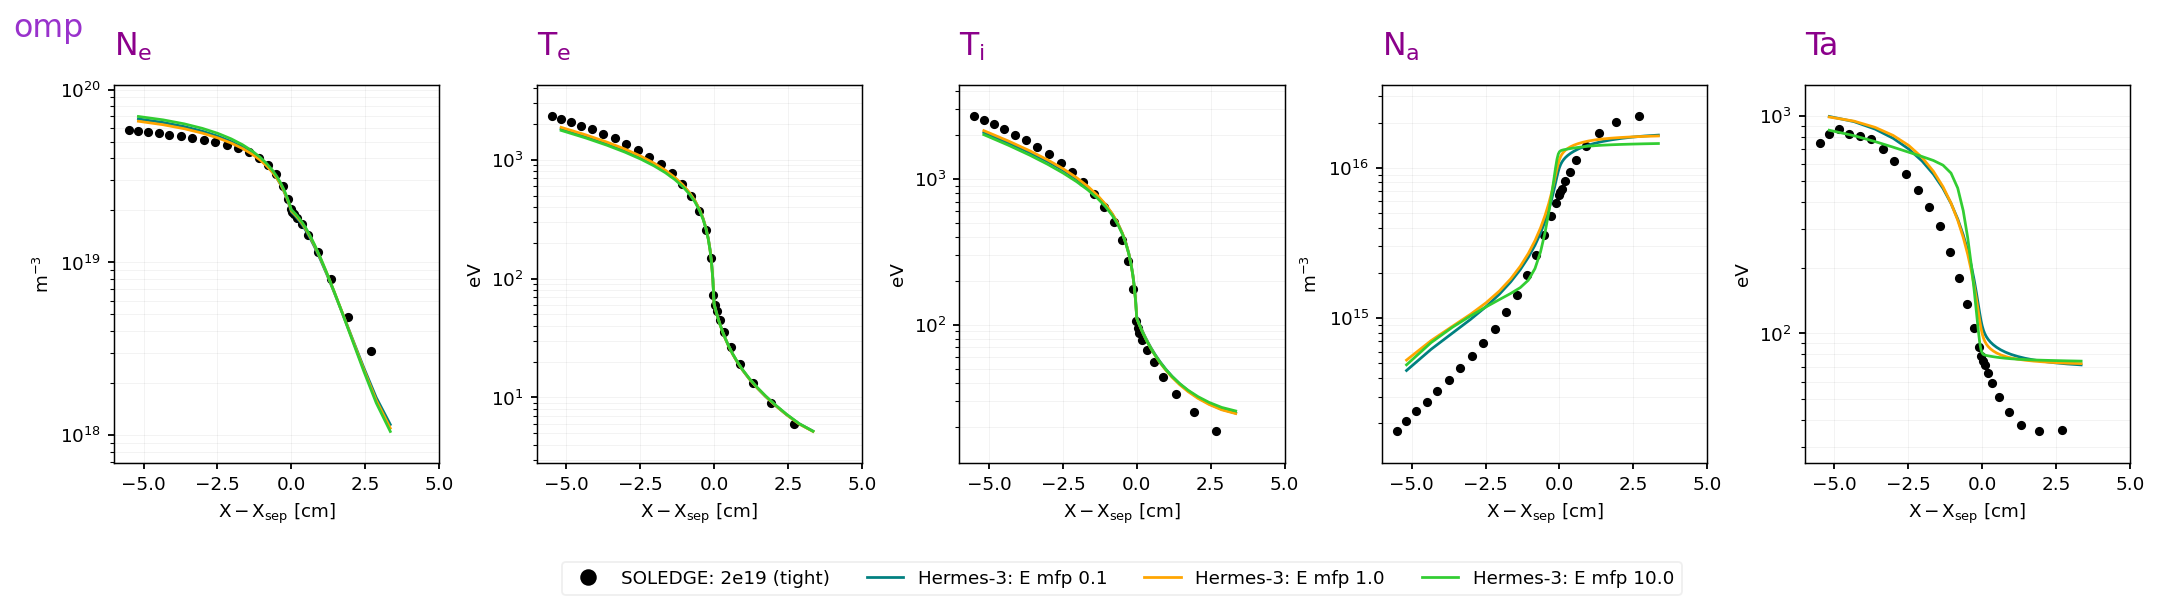

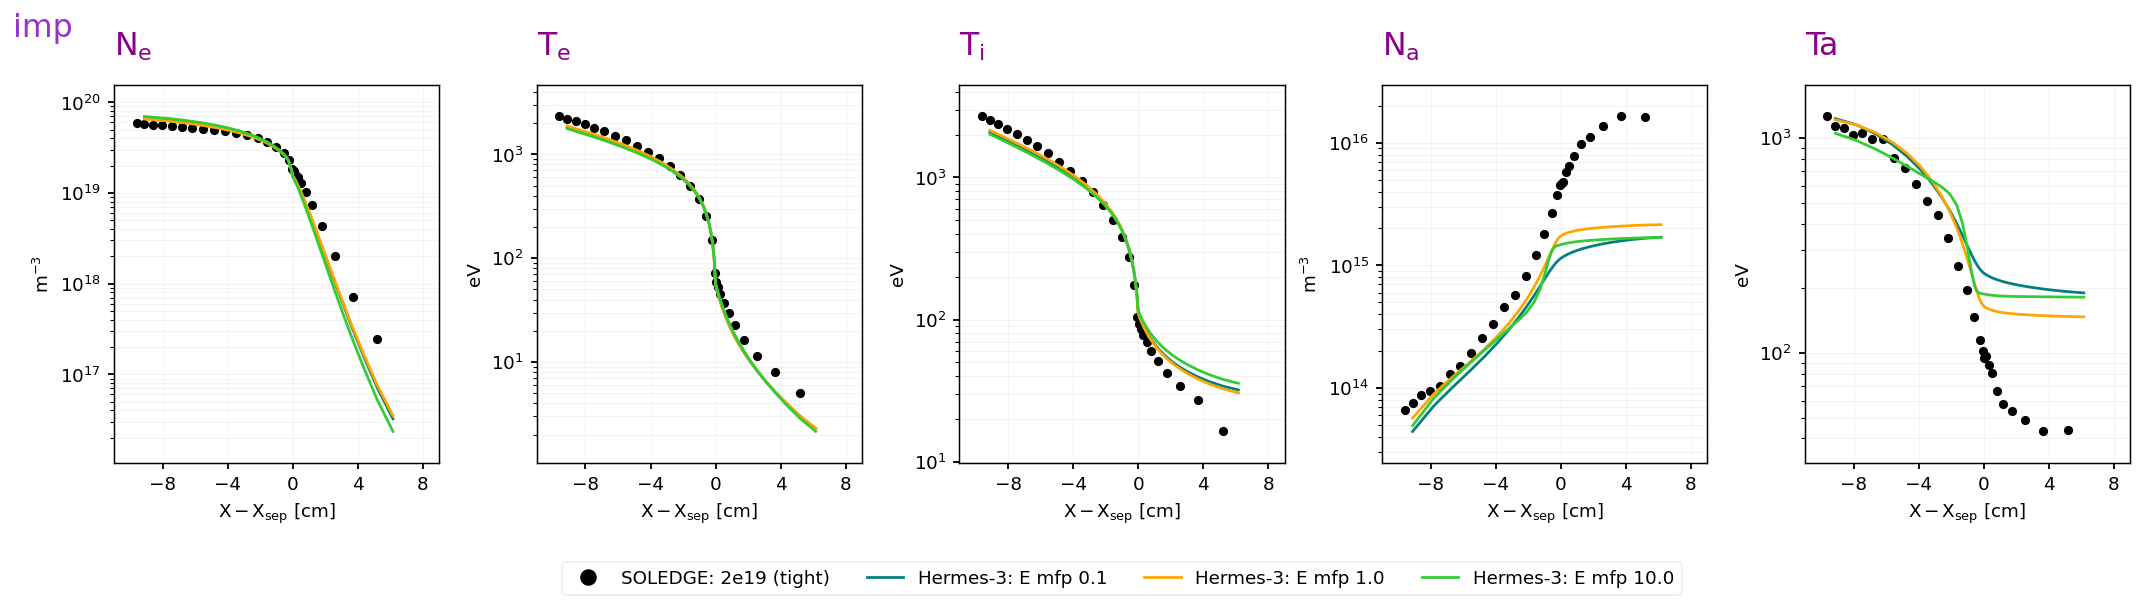

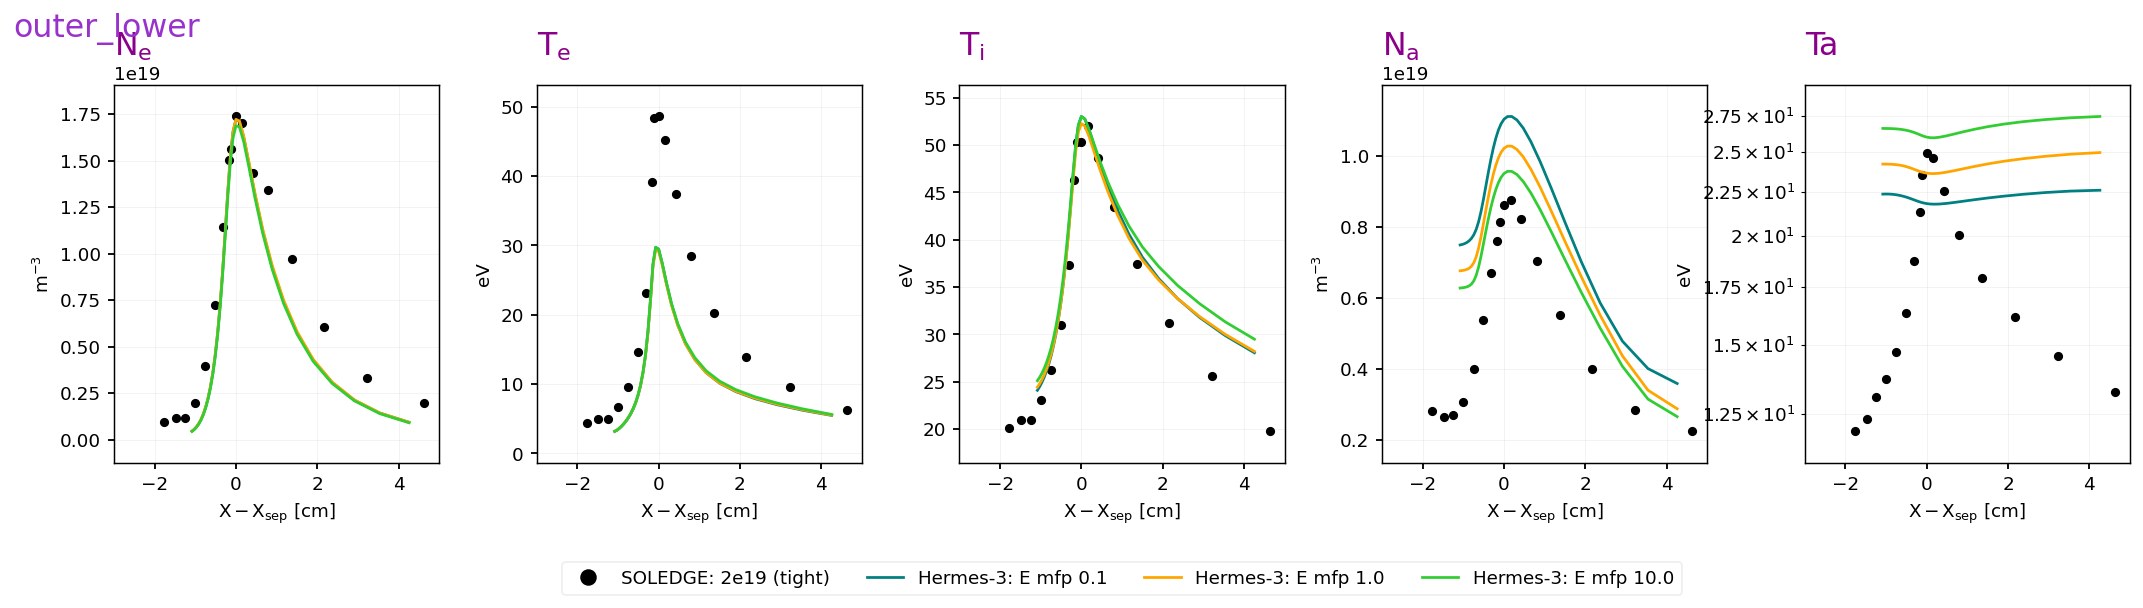

In [13]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    # "SOLPS: 2e19 (tight)" : dict(data=sp["nsep_3e19"], color="red"),
    
    # "Hermes-3: frec tune" : dict(data=hr['frec_tune'], color = "teal"),
    # r"Hermes-3: combined cond/conv" : dict(data=hr['afn_tunefrec'], color = "darkorange"),
    r"Hermes-3: E mfp 0.1" : dict(data=hr['afnE_mfp0.1'], color = "teal"),
    r"Hermes-3: E mfp 1.0" : dict(data=hr['afnE_mfp1'], color = "orange"),
    r"Hermes-3: E mfp 10.0" : dict(data=hr['afnE_mfp10'], color = "limegreen"),
    # r"Hermes-3: New, MFP=10m" : dict(data=hr['afnnew_mfp10'], color = "deeppink"),

    },
    regions = ["omp", "imp", "outer_lower"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    mode = "log",
    dpi = 120,
    lw = 2
)

# Impact of tuning prticle flux limiter

In [13]:
casestore.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp1', 'afnE_mfp0.1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25', 'afnE_mfp1_cond0.25_flim0.9', 'afnE_mfp1_cond0.25_flim0.7', 'afnE_mfp1_cond0.25_flim0.5', 'afnE_mfp1_cond0.25_flim0.25', 'afnE_mfp1_cond0.25_frec0.48', 'afnE_mfp1_cond0.25_frec0.68'])

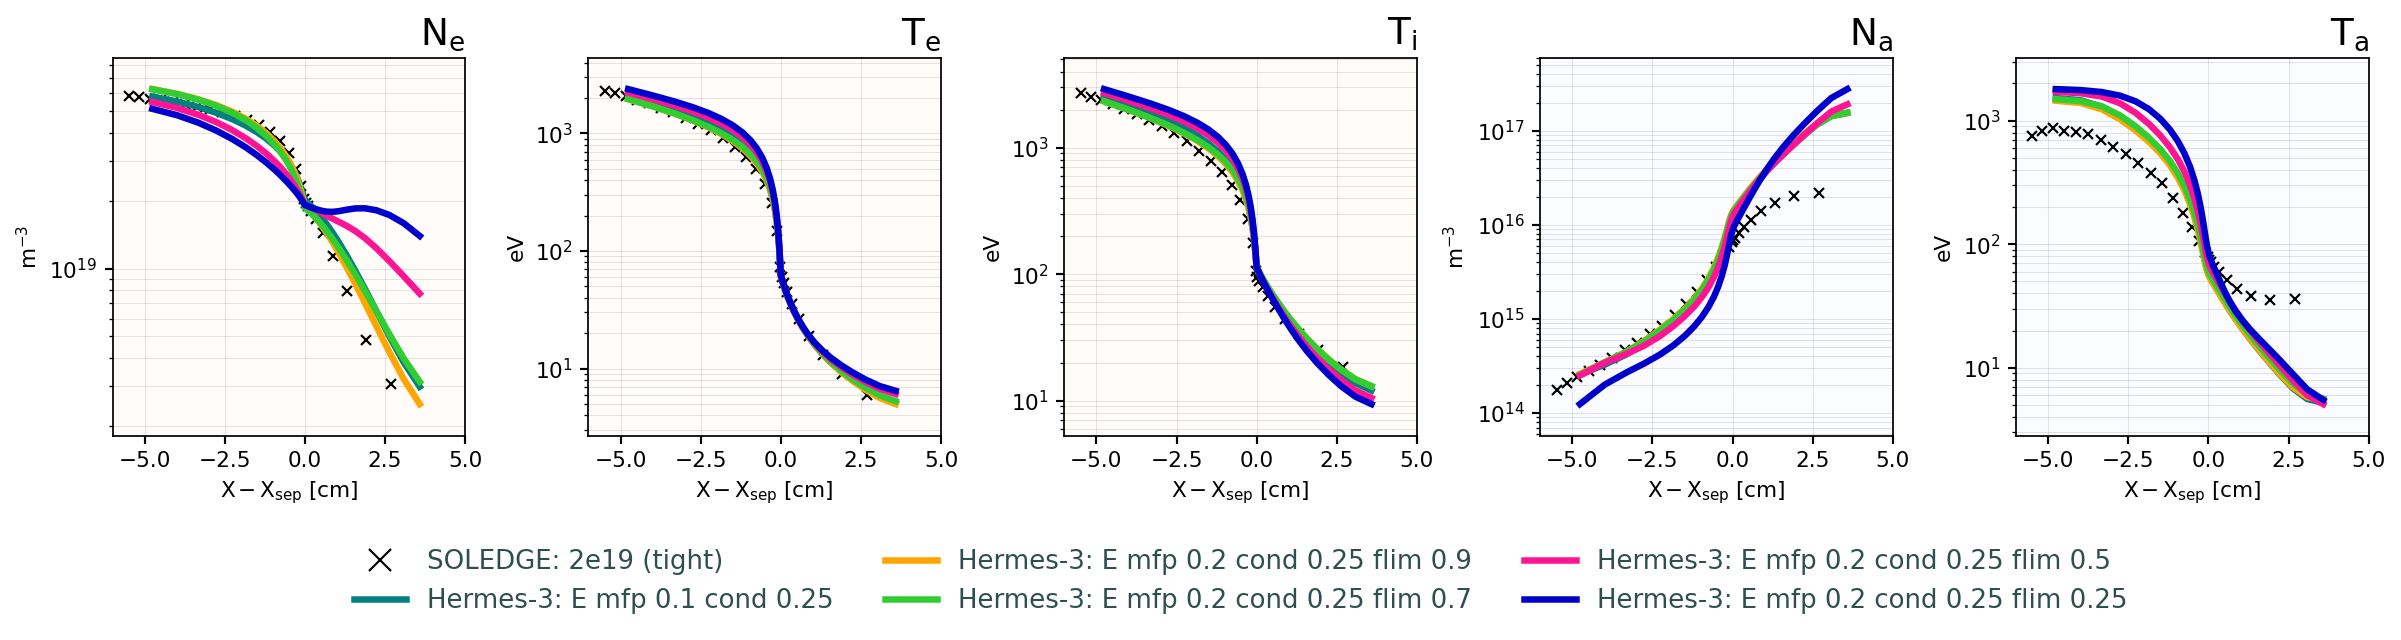

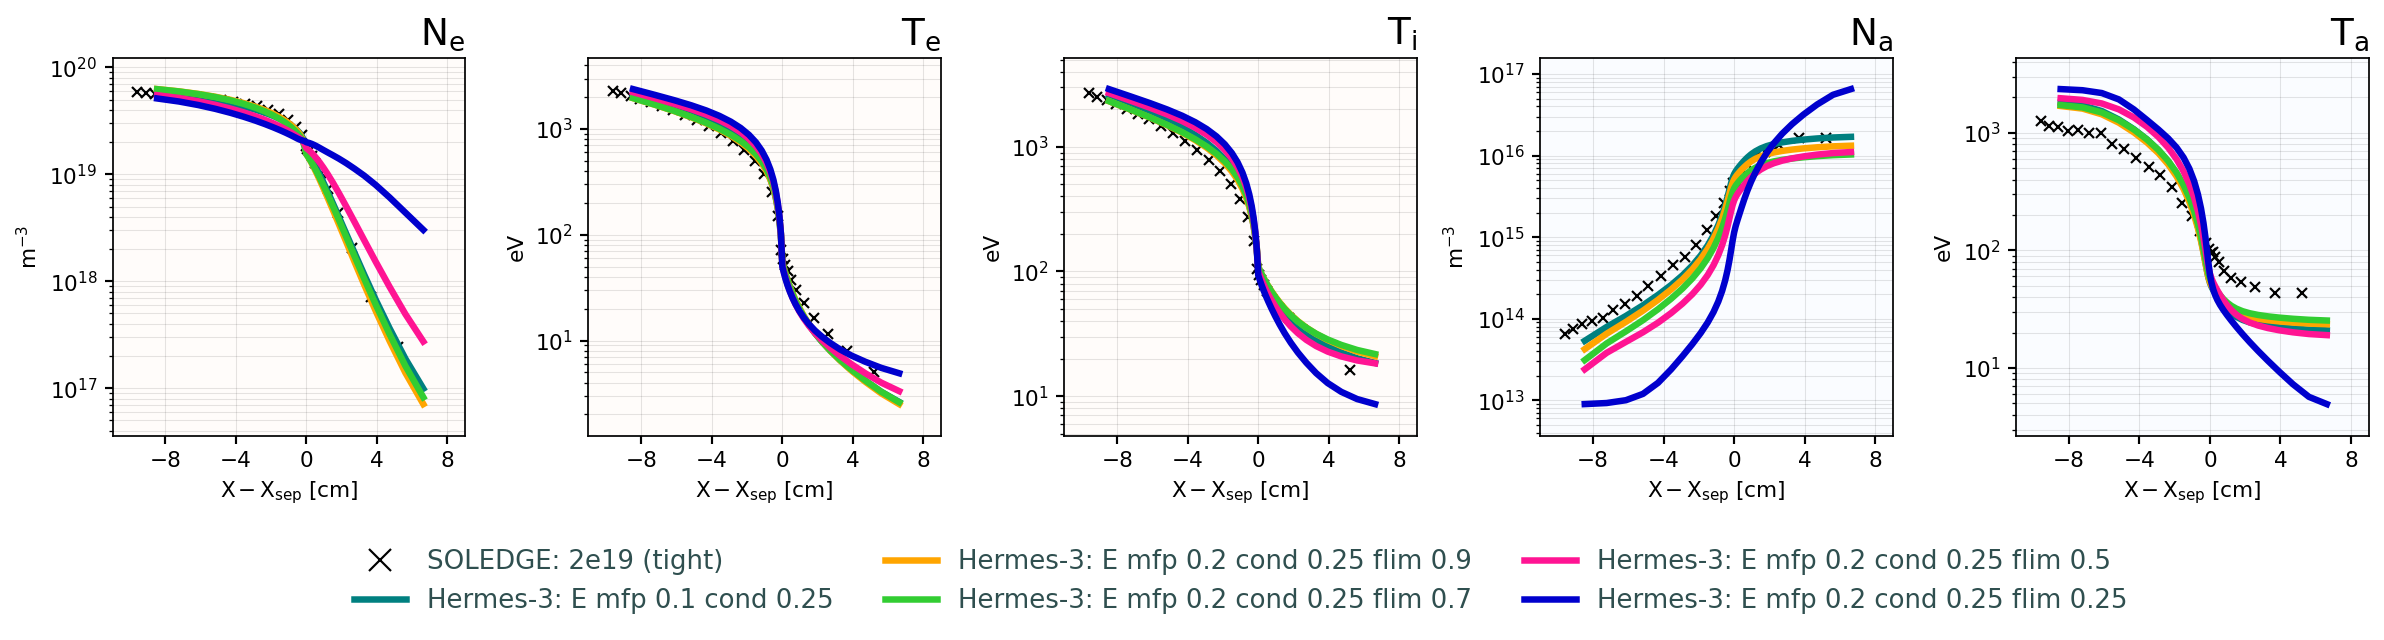

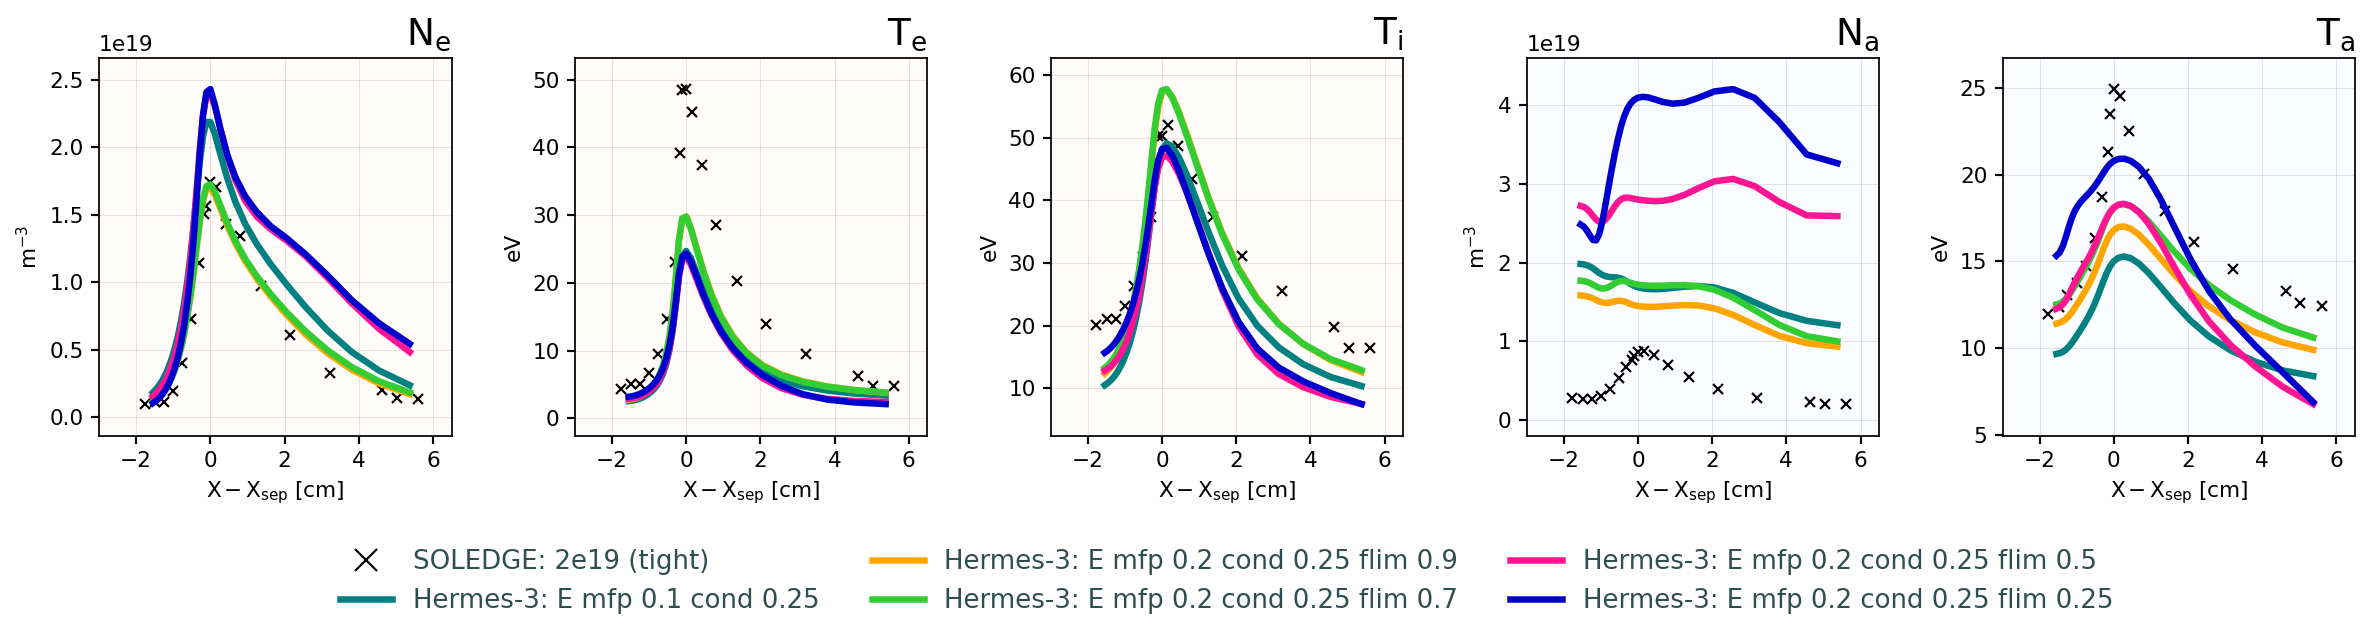

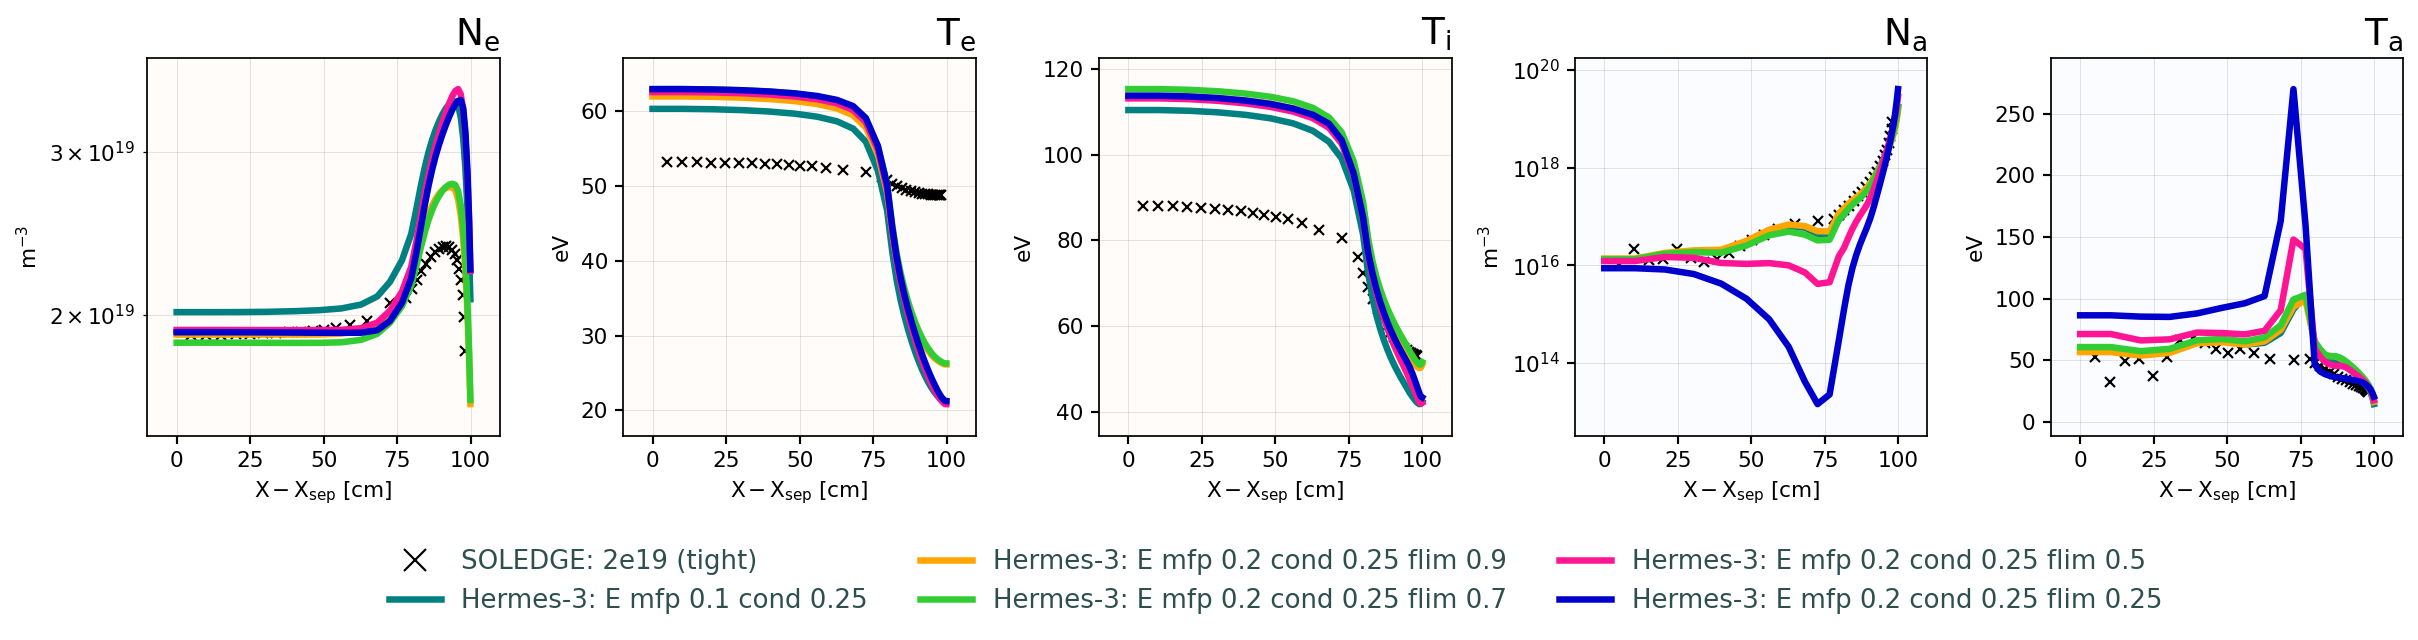

In [8]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    # "SOLPS: 2e19 (tight)" : dict(data=sp["nsep_3e19"], color="red"),
    
    # "Hermes-3: frec tune" : dict(data=hr['frec_tune'], color = "teal"),
    # r"Hermes-3: combined cond/conv" : dict(data=hr['afn_tunefrec'], color = "darkorange"),
    r"Hermes-3: E mfp 0.1 cond 0.25" : dict(data=hr['afnE_mfp1_cond0.25'], color = "teal"),
    r"Hermes-3: E mfp 0.2 cond 0.25 flim 0.9" : dict(data=hr['afnE_mfp1_cond0.25_flim0.9'], color = "orange"),
    r"Hermes-3: E mfp 0.2 cond 0.25 flim 0.7" : dict(data=hr['afnE_mfp1_cond0.25_flim0.7'], color = "limegreen"),
    r"Hermes-3: E mfp 0.2 cond 0.25 flim 0.5" : dict(data=hr['afnE_mfp1_cond0.25_flim0.5'], color = "deeppink"),
    r"Hermes-3: E mfp 0.2 cond 0.25 flim 0.25" : dict(data=hr['afnE_mfp1_cond0.25_flim0.25'], color = "mediumblue"),
    # r"Hermes-3: New, MFP=10m" : dict(data=hr['afnnew_mfp10'], color = "deeppink"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    mode = "log",
    dpi = 120,
    lw = 2
)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


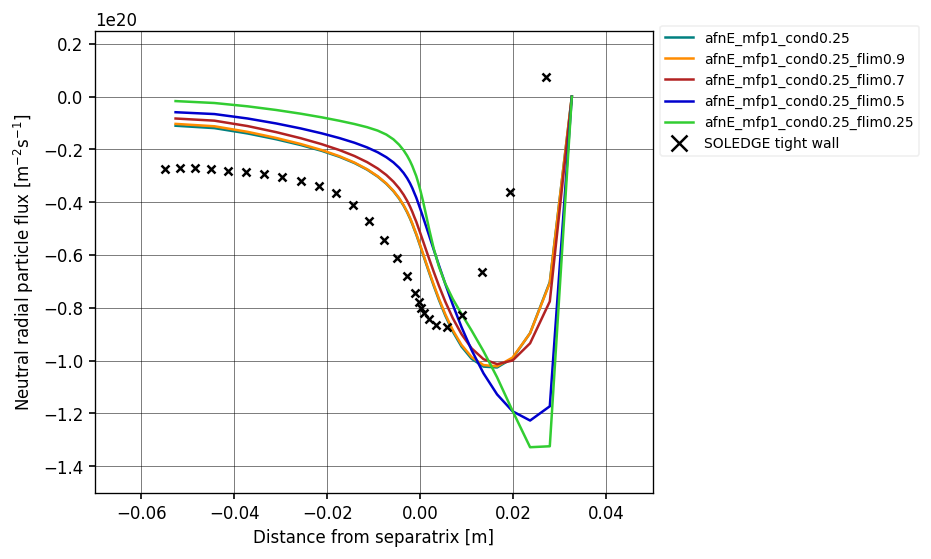

In [16]:
fig, ax = plt.subplots(dpi = 120)
cases = ["afnE_mfp1_cond0.25", "afnE_mfp1_cond0.25_flim0.9", "afnE_mfp1_cond0.25_flim0.7", 'afnE_mfp1_cond0.25_flim0.5', 'afnE_mfp1_cond0.25_flim0.25']
labels = None
colors =None
# labels = ["flim=1", "flim=0.9", "flim=0.7"]

# colors = ["teal", "darkorange", "limegreen", "deeppink"]

for i, case in enumerate(cases):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    
    label = case if labels is None else labels[i]
    
    kwargs = {} if colors is None else dict(color = colors[i])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = label, **kwargs)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE tight wall", c = "black")


ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlim(-0.07, 0.05)
ax.set_ylim(-1.5e20, 0.25e20)
ax.set_title("")
casestore.keys()
ax.grid(color = "k", alpha = 1)

# Impact of tuning fast recycling again on cond=0.25

In [ ]:
casestore.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp1', 'afnE_mfp0.1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25', 'afnE_mfp1_cond0.25_flim0.9', 'afnE_mfp1_cond0.25_flim0.7', 'afnE_mfp1_cond0.25_flim0.5', 'afnE_mfp1_cond0.25_flim0.25', 'afnE_mfp1_cond0.25_frec0.48', 'afnE_mfp1_cond0.25_frec0.68'])

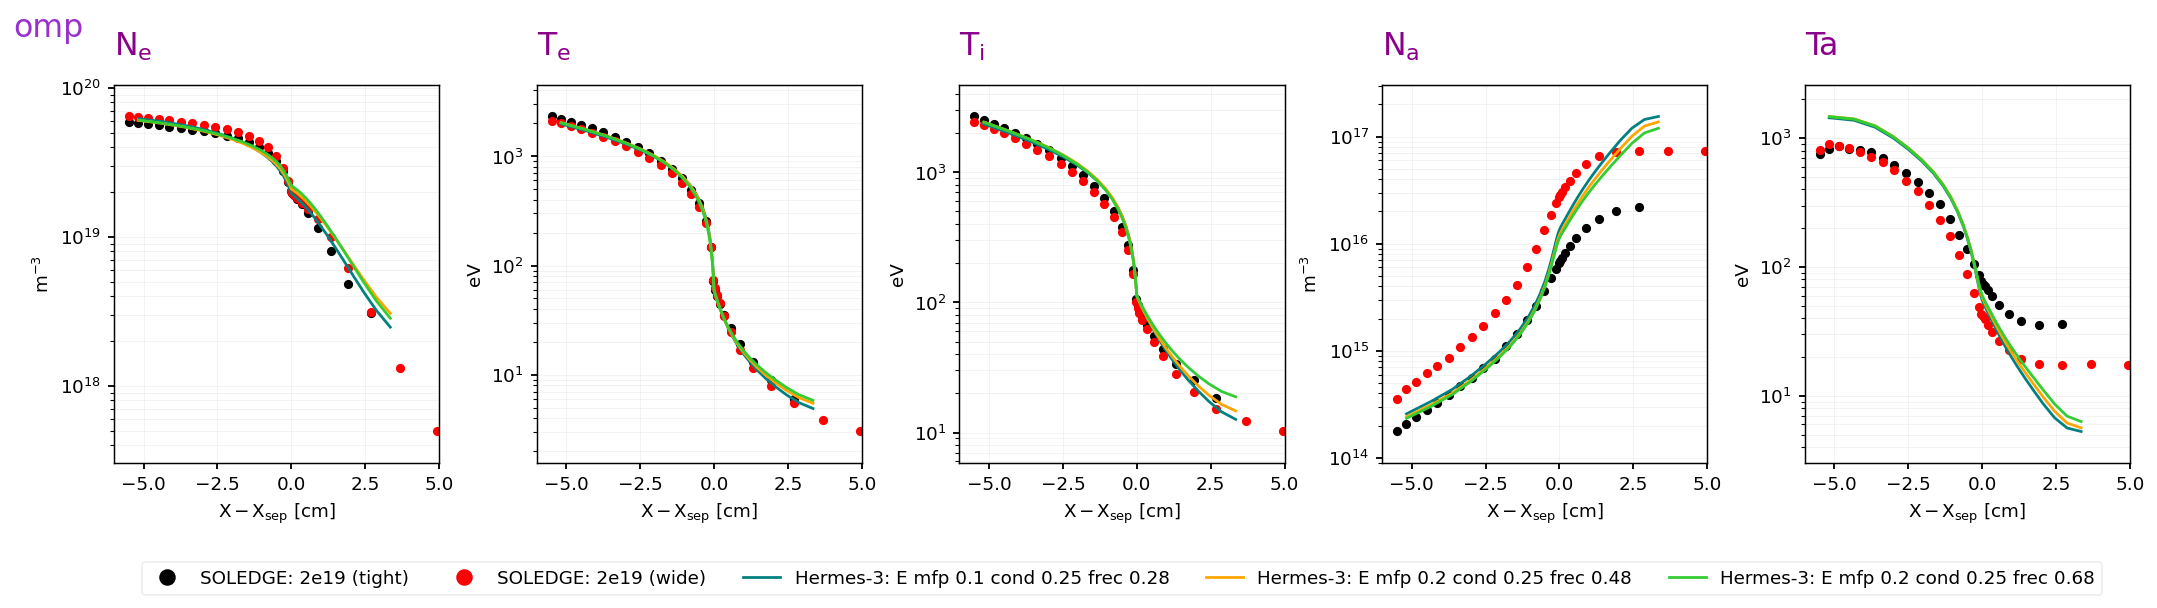

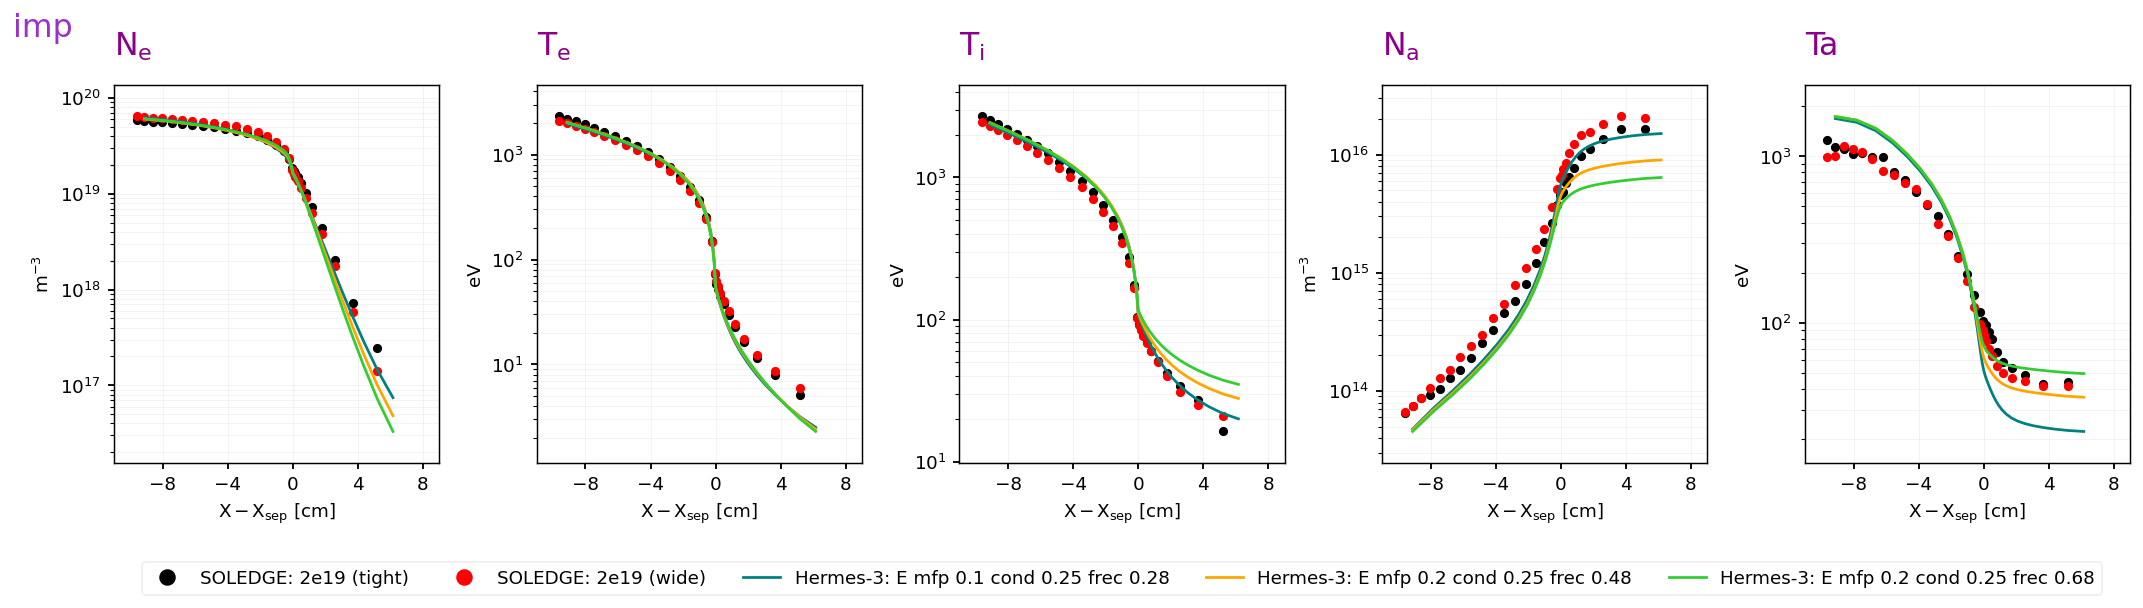

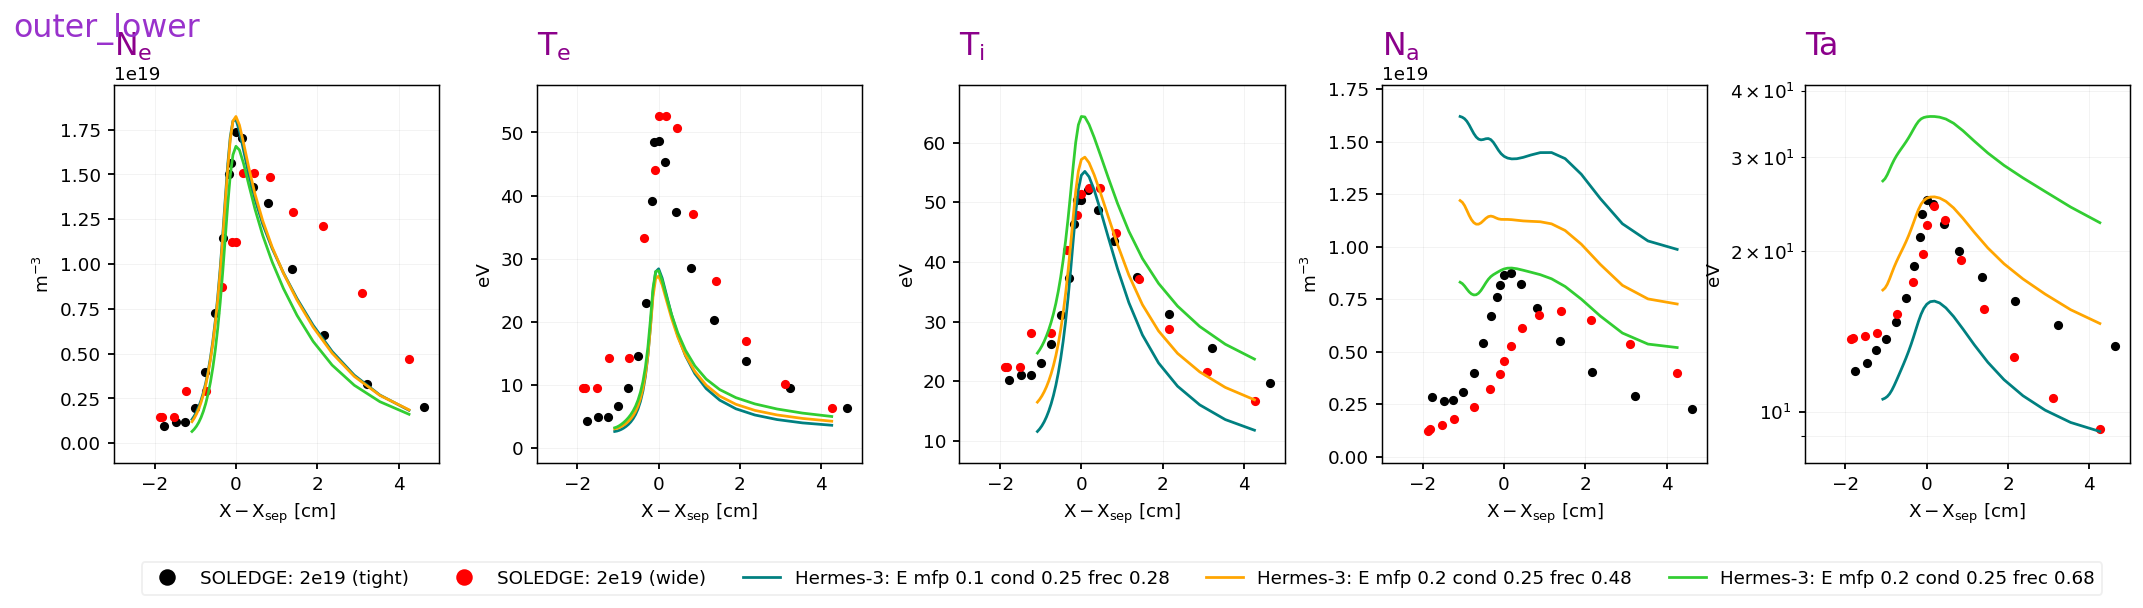

In [21]:

plt.close("all")
lineplot_compare(
    cases = { 
    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    "SOLEDGE: 2e19 (wide)" : dict(data=sl["widewall_2e19"], color="red"),
    
    r"Hermes-3: E mfp 0.1 cond 0.25 frec 0.28" : dict(data=hr['afnE_mfp1_cond0.25'], color = "teal"),
    r"Hermes-3: E mfp 0.2 cond 0.25 frec 0.48" : dict(data=hr['afnE_mfp1_cond0.25_frec0.48'], color = "orange"),
    r"Hermes-3: E mfp 0.2 cond 0.25 frec 0.68" : dict(data=hr['afnE_mfp1_cond0.25_frec0.68'], color = "limegreen"),
    },
    regions = ["omp", "imp", "outer_lower"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    mode = "log",
    dpi = 120,
    lw = 2
)

In [ ]:
fig, ax = plt.subplots(dpi = 120)
cases = ["afnE_mfp1_cond0.25", "afnE_mfp1_cond0.25_flim0.9", "afnE_mfp1_cond0.25_flim0.7", 'afnE_mfp1_cond0.25_flim0.5', 'afnE_mfp1_cond0.25_flim0.25']
labels = None
colors =None
# labels = ["flim=1", "flim=0.9", "flim=0.7"]

# colors = ["teal", "darkorange", "limegreen", "deeppink"]

for i, case in enumerate(cases):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    
    label = case if labels is None else labels[i]
    
    kwargs = {} if colors is None else dict(color = colors[i])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = label, **kwargs)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE tight wall", c = "black")


ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlim(-0.07, 0.05)
ax.set_ylim(-1.5e20, 0.25e20)
ax.set_title("")
casestore.keys()
ax.grid(color = "k", alpha = 1)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


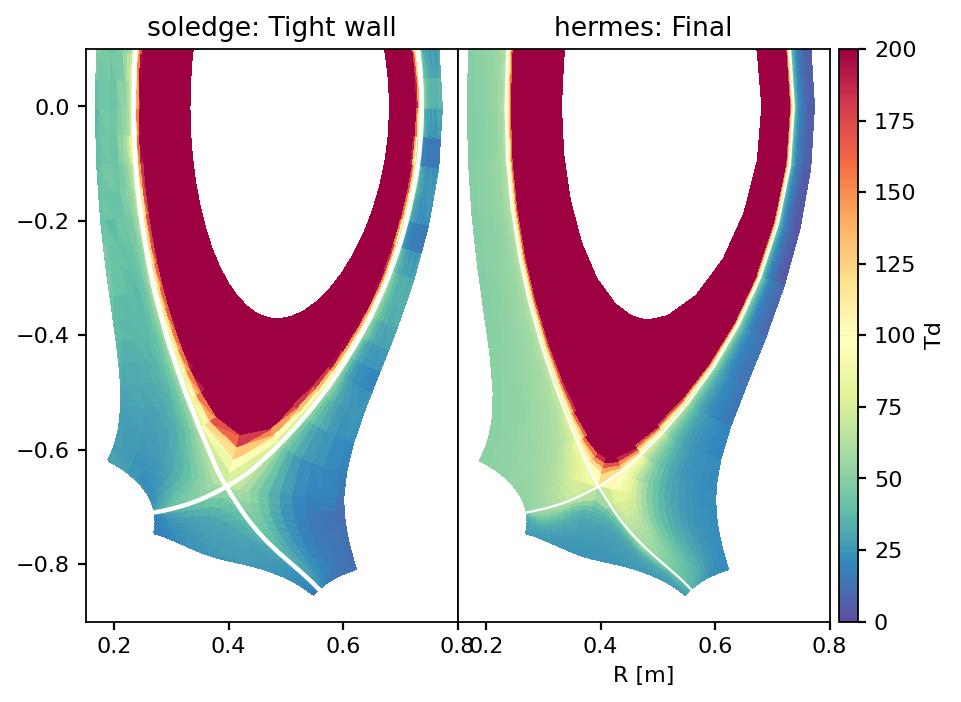

In [19]:
plt.close("all")
v = viewer_2d(
    "Td",
    [
        {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        # {"name" : "frec", "code" : "hermes", "ds" : casestore["frec"].ds.isel(t=-1)},
        # {"name" : "frec_new", "code" : "hermes", "ds" : casestore["frec_new"].ds.isel(t=-1)},
        
        # {"name" : "no afn", "code" : "hermes", "ds" : casestore["frec_tune"].ds.isel(t=-1)},
        # {"name" : "Old", "code" : "hermes", "ds" : casestore['afn_tunefrec_seplims_mfp0.1'].ds.isel(t=-1)},
        # {"name" : r"D, cond$\alpha$=1.00", "code" : "hermes", "ds" : casestore['afnD_mfp1'].ds.isel(t=-1)},
        {"name" : r"Final", "code" : "hermes", "ds" : casestore['afnE_mfp1_cond0.25_frec0.68'].ds.isel(t=-1)},
    ],
    logscale = False,
    vmin = 0,
    vmax = 200,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.1),
    xlim = (0.15, 0.8),
    wspace = 0.0,
    cmap = "Spectral_r",
    slider = False
)

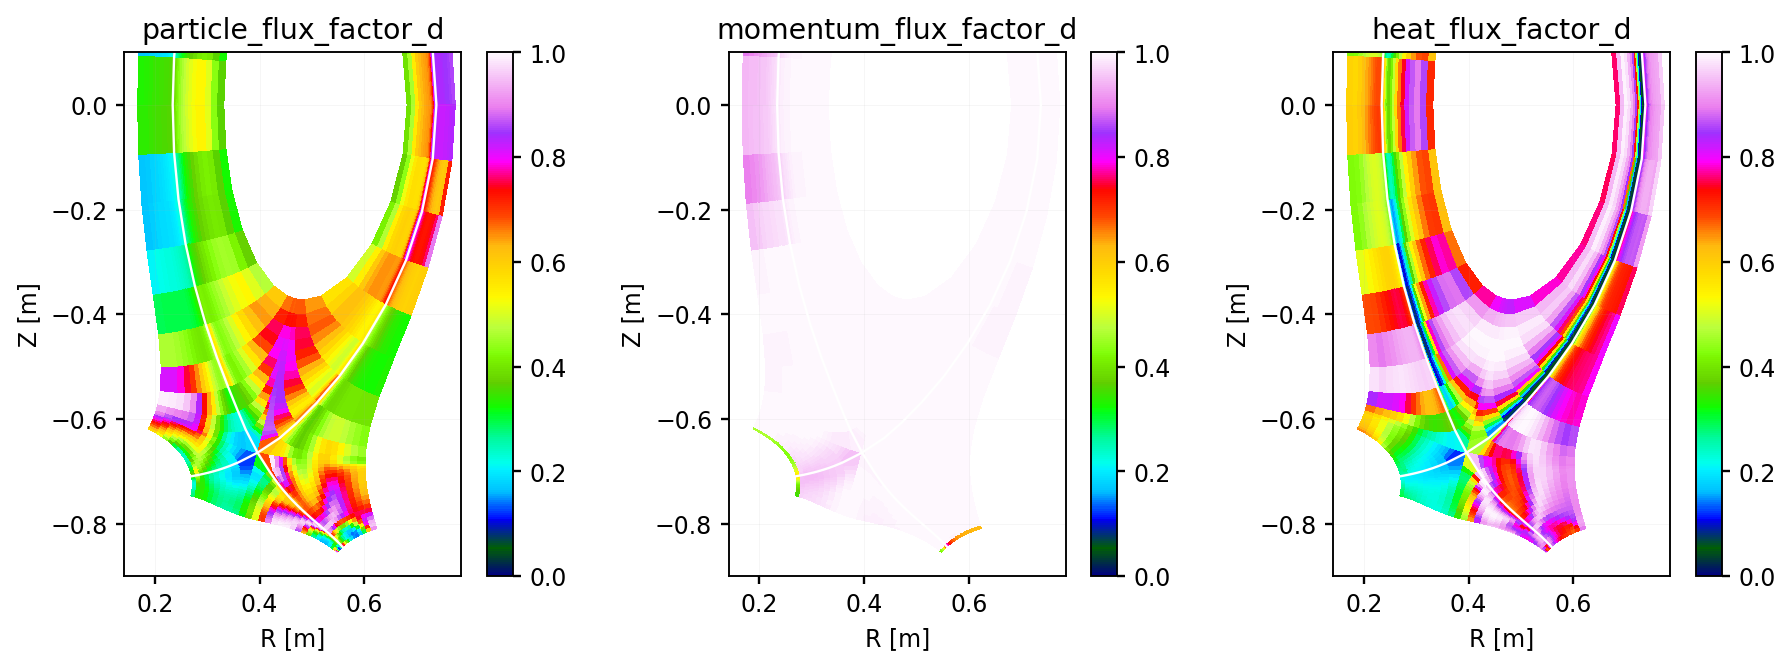

In [71]:
ds = casestore["afnnew_mfp0.1"].ds
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
# ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

In [12]:
casestore.keys()

dict_keys(['afnBseplims_mfp1', 'afnD_mfp1', 'afnE_mfp1', 'afnE_mfp0.1', 'afnE_mfp10', 'afnE_mfp1_cond0.75', 'afnE_mfp1_cond0.5', 'afnE_mfp1_cond0.25', 'afnE_mfp1_cond0.25_flim0.9', 'afnE_mfp1_cond0.25_flim0.7'])

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


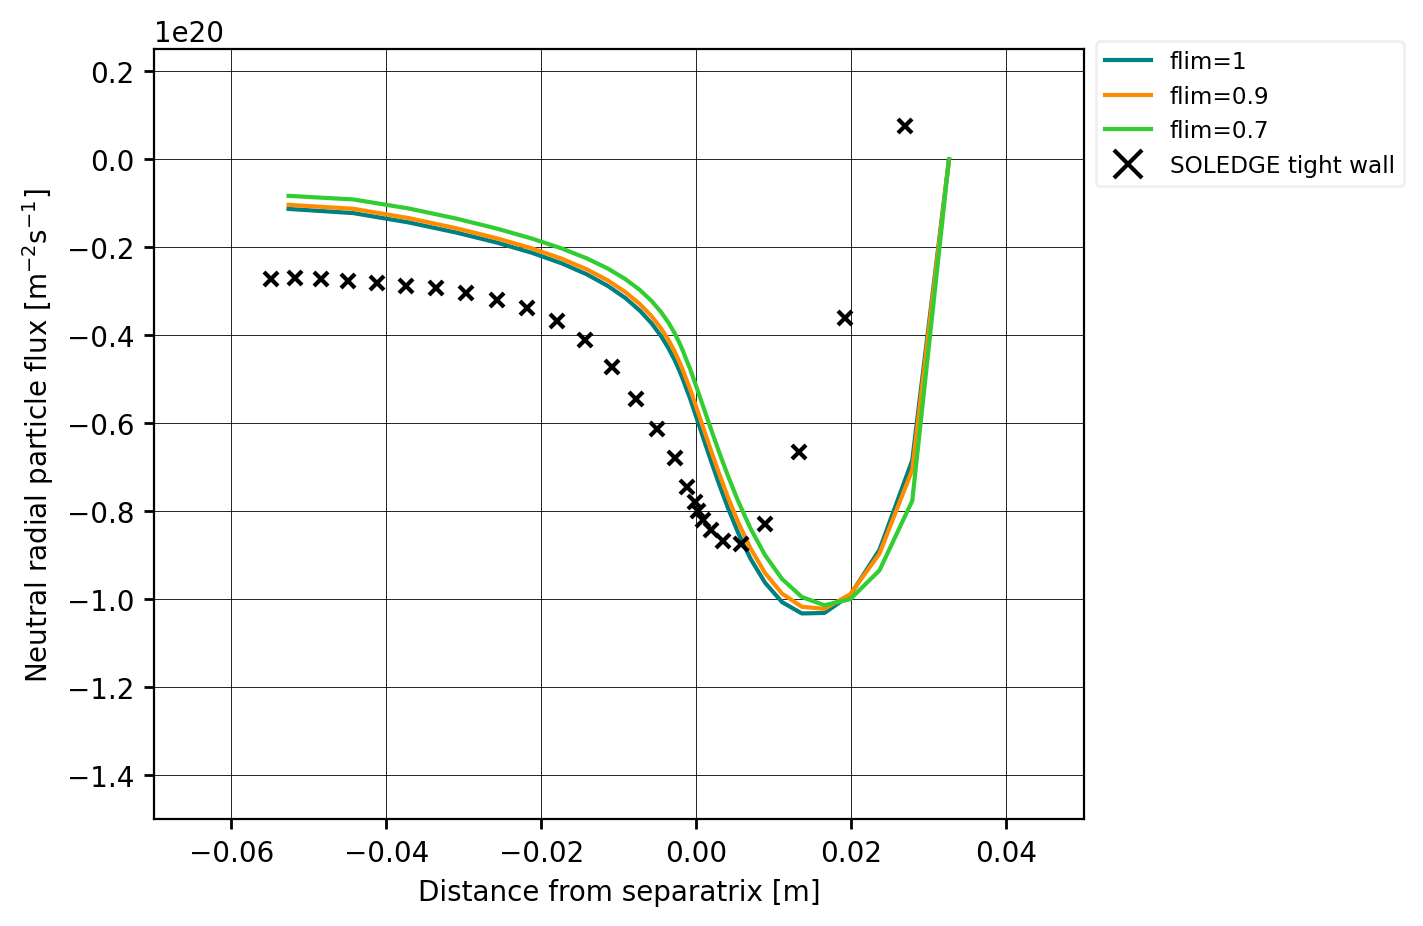

In [13]:
fig, ax = plt.subplots(dpi = 200)


cases = ["afnE_mfp1_cond0.25", "afnE_mfp1_cond0.25_flim0.9", "afnE_mfp1_cond0.25_flim0.7"]
labels = ["flim=1", "flim=0.9", "flim=0.7"]
colors = ["teal", "darkorange", "limegreen", "deeppink"]

# cases = ["afnE_mfp1", "afnE_mfp1_cond0.75", "afnE_mfp1_cond0.5", "afnE_mfp1_cond0.25"]
# labels = ["alpha=1", "alpha=0.75", "alpha=0.5", "alpha=0.25"]
# colors = ["teal", "darkorange", "limegreen", "deeppink"]

# cases = ["afnBseplims_mfp1", "afnD_mfp1", "afnE_mfp1"]
# labels = ["B", "D", "E"]
# colors = ["teal", "darkorange", "limegreen"]

# cases = ["afnE_mfp0.1", "afnE_mfp1", "afnE_mfp10"]
# labels = ["MFP 0.1m", "MFP 1.0m", "MFP 10m"]
# colors = ["teal", "darkorange", "limegreen"]

# cases = casestore
# labels = None
# colors = None
for i, case in enumerate(cases):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    
    label = case if labels is None else labels[i]
    
    kwargs = {} if colors is None else dict(color = colors[i])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = label, **kwargs)

# ax2 = ax.twinx()
# ax2.plot(dist, omp["particle_flux_factor_d"])

# SOLPS
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (lo res)", color = "black", lw=0, marker = "o", ms = 3)
# ax.plot(sp["16x_mc"].regions["omp"].index, sp["16x_mc"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (hi res)", color = "grey", lw=0, marker = "o", ms = 3)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE tight wall", c = "black")

# slc = SOLEDGEcase(path = soledgecases["widewall_2e19"])
# df = slc.get_1d_radial_data(["vxni", "Nni"])
# df["NVxn"] = df["vxni"] * df["Nni"]
# ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE wide wall", c = "darkorange")

ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlim(-0.07, 0.05)
ax.set_ylim(-1.5e20, 0.25e20)
ax.set_title("")
casestore.keys()
ax.grid(color = "k", alpha = 1)

In [30]:
casestore.k
eys()

dict_keys(['afn_tunefrec', 'afn_newfrec_seplims_mfp1', 'afn_tunefrec_seplims_mfp0.1', 'afnnew_mfp0.1', 'afnnew_mfp1', 'afnnew_mfp10'])

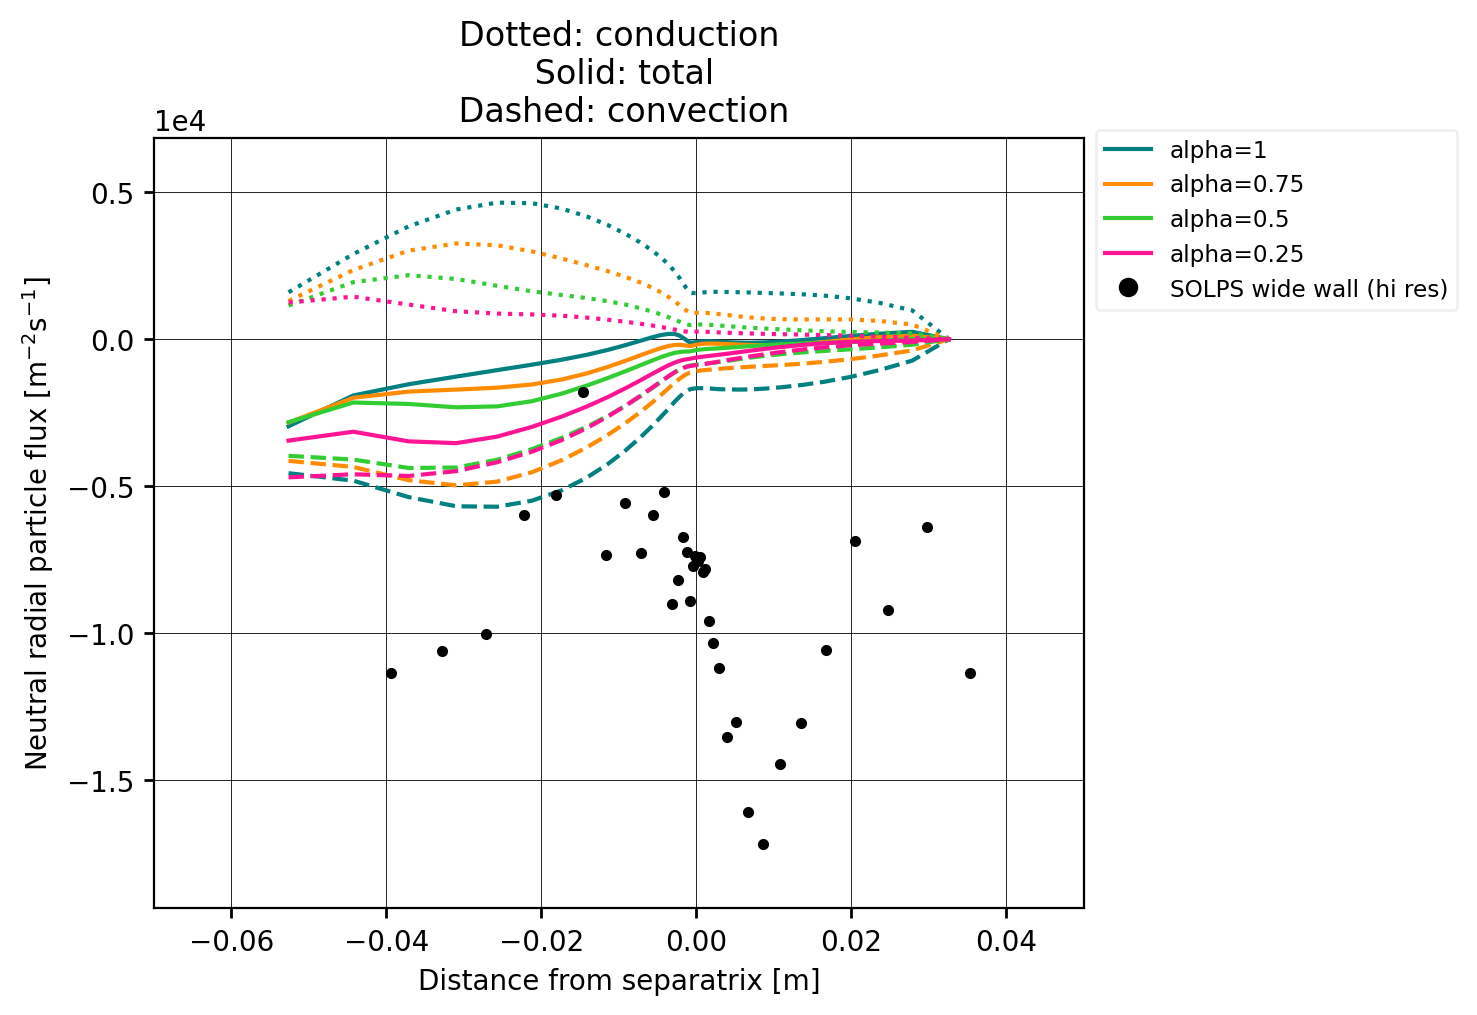

In [64]:
fig, ax = plt.subplots(dpi = 200)

colors = ["teal", "darkorange", "firebrick", "limegreen", "mediumblue", "darkorchid", "deeppink", 
                                                   "#1E90FF", "forestgreen", "#4169e1", "darkgoldenrod", "#9370db", "crimson", "#2f4f4f" ]

# labels = ["Old", "New", "New, MFP=10m"]
# cases = ["afn_tunefrec_seplims_mfp0.1", "afnnew_mfp0.1", "afnnew_mfp10"]

# cases = ["afnE_mfp1", "afnE_mfp1_cond0.75", "afnE_mfp1_cond0.5", "afnE_mfp1_cond0.25"]
# labels = ["alpha=1", "alpha=0.75", "alpha=0.5", "alpha=0.25"]

# cases = ["afnBseplims_mfp1", "afnD_mfp1", "afnE_mfp1"]
# labels = ["B", "D", "E"]
# colors = ["teal", "darkorange", "limegreen"]

# cases = ["afnE_mfp0.1", "afnE_mfp1", "afnE_mfp10"]
# labels = ["MFP 0.1m", "MFP 1.0m", "MFP 10m"]
# colors = ["teal", "darkorange", "limegreen"]

cases = ["afnE_mfp1", "afnE_mfp1_cond0.75", "afnE_mfp1_cond0.5", "afnE_mfp1_cond0.25"]
labels = ["alpha=1", "alpha=0.75", "alpha=0.5", "alpha=0.25"]
colors = ["teal", "darkorange", "limegreen", "deeppink"]

for i, case in enumerate(cases):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), color = colors[i], ls = ":")
    ax.plot(dist, omp["hf_perp_conv_R_d"] / (omp["dy"]*omp["dz"]),  color = colors[i], ls = "--")
    ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]),  color = colors[i], ls = "-", label = labels[i])

# SOLPS
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (lo res)", color = "black", lw=0, marker = "o", ms = 3)
ax.plot(sp["16x_mc"].regions["omp"].index, sp["16x_mc"].regions["omp"]["pefluxa3da"] * -1, label = "SOLPS wide wall (hi res)", color = "black", lw=0, marker = "o", ms = 3)


ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlim(-0.07, 0.05)
# ax.set_ylim(-1.0e20, 1.0e20)
ax.set_title("Dotted: conduction\n Solid: total\n Dashed: convection")
ax.grid(c = "k", alpha = 1)

In [67]:
hr.keys()

dict_keys(['afn_tunefrec', 'afn_newfrec_seplims_mfp1', 'afn_tunefrec_seplims_mfp0.1', 'afnnew_mfp0.1', 'afnnew_mfp1', 'afnnew_mfp10'])

In [70]:
calculate_simple_heat_balance(casestore['afnnew_mfp10'].ds.isel(t=-1))

Wall reflective cooling:
inner_wall  : -0.011 [MW]
outer_wall  : -0.093 [MW]
pfr         : -0.084 [MW]
targets     : -0.036 [MW]
Total       : -0.224 [MW]

Recycling neutral energy source:
Total       : 0.193 [MW]


In [46]:
ds = casestore["afn_new"].ds.isel(t=-1)
m = ds.metadata

In [65]:
"""
Simple heat balance with things hardcoded
Currently only reflective wall cooling
"""
if ds["t"].shape != ():
    raise Exception("Please supply a single time slice")
places = {}

places["inner_wall  "] = ds.hermesm.select_region("inner_sol_edge")
places["outer_wall  "] = ds.hermesm.select_region("outer_sol_edge")
places["pfr         "] = ds.hermesm.select_region("pfr_edge")

if "Ed_wall_refl" in ds.data_vars:
    hflows = {}
    for place in places:
        ds_place = places[place]
        hflows[place] = ()
        hflows[place] = (ds_place["Ed_wall_refl"] * ds_place["dv"] ).sum().values * 1e-6
        
    hflows["targets     "] = (ds["Ed_target_refl"] * ds["dv"]).sum().values * 1e-6
    
    print("Wall reflective cooling:")
    tot = 0
    for name in hflows:
        print(f"{name}            : {hflows[name]:.3f} [MW]")
        tot += hflows[name]
        
    print(f"Total                   : {tot:.3f} [MW]\n")
else:
    print("No wall heat fluxes found in dataset")
    
print("Recycling neutral energy source:")
en_rec = (ds["Ed_target_recycle"] * ds["dv"]).sum(["x", "theta"]).values * 1e-6
print(f"Total                   : {en_rec:.3f} [MW]")

print(f"\nBC heat fluxes:")
sheath_i = 0
sheath_e = 0
for target in m["targets"]:
    sheath_i += ds[f"hf_{target}_target_d+"].sum().values * 1e-6
    sheath_e += ds[f"hf_{target}_target_e"].sum().values * 1e-6
    
print(f"Target sheath ion flux  : {sheath_i:.3f} [MW]")
print(f"Target sheath ele flux  : {sheath_e:.3f} [MW]")

Wall reflective cooling:
inner_wall              : -0.015 [MW]
outer_wall              : -0.180 [MW]
pfr                     : -0.176 [MW]
targets                 : -0.069 [MW]
Total                   : -0.439 [MW]

Recycling neutral energy source:
Total                   : 0.686 [MW]

BC heat fluxes:


NameError: name 'm' is not defined

In [58]:
0.7*0.8

0.5599999999999999

In [47]:
hf_target = 0
for target in m["targets"]:
    hf_target += ds[f"hf_{target}_target_d+"].sum().values * 1e-6
    
hf_target

-1.0916816241749911

In [39]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds)
    casestore[name].ds = calculate_target_fluxes(casestore[name].ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


# SOLPS

In [5]:
sp["nsep_2e19"].regions["omp"].columns

Index(['an3da', 'dn3da', 'dp3da', 'ke3da', 'ki3da', 'mn3da', 'ne3da', 'po3da',
       'te3da', 'ti3da', 'vs3da', 'vx3da', 'vy3da', 'vol3da', 'tie3da',
       'dab23da', 'tab23da', 'dmb23da', 'tmb23da', 'dib23da', 'tib23da',
       'rfluxa3da', 'rfluxm3da', 'pfluxa3da', 'pfluxm3da', 'refluxa3da',
       'refluxm3da', 'pefluxa3da', 'pefluxm3da', 'emiss3da', 'emissmol3da',
       'srcml3da', 'edissml3da', 'pab23da', 'pmb23da', 'pib23da', 'dnb23da',
       'pnb23da', 'tnb23da', 'emisstot3da', 'daeb23da', 'dmeb23da', 'dneb23da',
       'danb23da', 'taib23da', 'tmib23da', 'tnib23da', 'vrab23da', 'vpab23da',
       'vtab23da', 'vrmb23da', 'vpmb23da', 'vtmb23da', 'e0ab23da', 'e0mb23da',
       'eneutrad3da', 'emolrad3da', 'eionrad3da', 'etotrad3da', 'totrad3da',
       'Zeff3da', 'AMJUEL_H.4_2.1.5_3da', 'AMJUEL_H.10_2.1.5_3da',
       'AMJUEL_H.2_3.1.8FJ_3da', 'HYDHEL_H.2_2.2.9_3da',
       'HYDHEL_H.2_2.2.5_3da', 'HYDHEL_H.2_2.2.10_3da', 'AMJUEL_H.0_0.3T_3da',
       'AMJUEL_H.1_0.3T_3da', 'A

In [23]:
bal = nc.Dataset(os.path.join(solpscases["nsep_2e19"], "balance.nc"))

In [24]:
var = bal["pefluxa"][:]

b2fgmtry loaded from .pkl


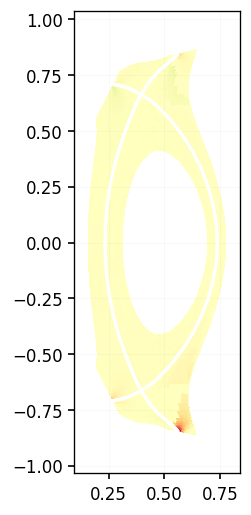

In [30]:
p = SOLPSplot(path = solpscases["nsep_2e19"], data = var)

fig, ax = plt.subplots()
p.plot(ax = ax, vmin = -3e6, vmax = 3e6, cmap = "RdBu_r")

In [14]:
p.variables

NameError: name 'p' is not defined

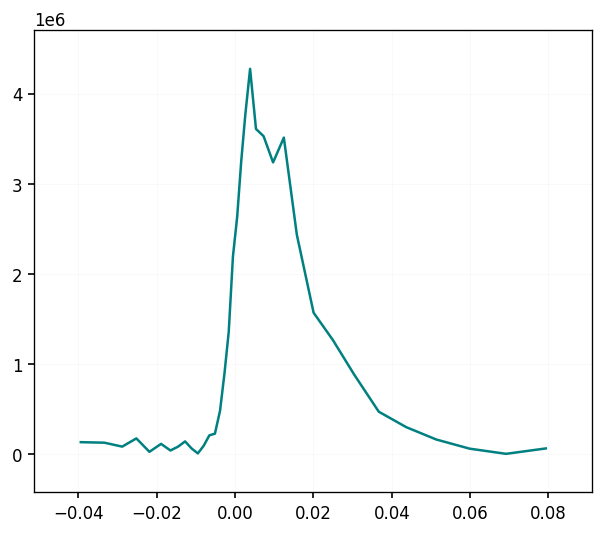

In [10]:
df = sp["nsep_2e19"].regions["outer_lower"]

fig, ax = plt.subplots()

ax.plot(df.index, df["refluxa3dr"])